<a href="https://colab.research.google.com/github/eunyeongkimm/nlp_hierarchical_game_review_absa/blob/main/game_review_transformer_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn -q

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 라벨링 데이터 불러오기 및 전처리

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#첫번째 열을 index로
df_annotated = pd.read_csv('/content/drive/MyDrive/annotated_sampled_fn.csv', index_col = 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_annotated.head()

,app_id,primary_genre,sentence,top_aspect,sub_aspect,sentiment
0,1086940,NaN,매일 새벽4시까지 하도록 하는 미친 게임,GAMEPLAY,GP_FUN,positive
1,1086940,NaN,150 시간만에 1회차 클리어햇다 미친 게임 갓 게임 진짜 내인생게임이다 2회차는 ...,GAMEPLAY,GP_CONTENT,positive
2,1086940,NaN,나는 500시간 넘게 플레이했지만 아직 엔딩을 한번밖에 보지 않았다.,GAMEPLAY,GP_CONTENT,positive
3,1086940,NaN,내 이쉐키야 살려줬더니 은혜를 원수로갚냐 한량쉐키야,OTHER,OTHER,neutral
4,1086940,NaN,말이 필요없는 명작 벌써 1년이 지났는데도 또 새로운 패치로 대규모 업데이트를 무료...,GAMEPLAY,GP_CONTENT,positive


In [4]:
# 필요한 컬럼만 선택
df_annotated = df_annotated[['app_id', 'sentence', 'top_aspect', 'sub_aspect', 'sentiment']].copy()

# other 제거
df_clean = df_annotated[df_annotated['top_aspect'] != 'OTHER'].copy()

print(df_clean['app_id'].value_counts())

app_id
1086940    2571
1091500    1883
413150     1036
578080      802
730         342
289070      337
1449850     305
227300      287
394360      237
3405690     173
489830      170
1222670     169
3450310     162
438100      157
813780      149
570         144
431960       87
Name: count, dtype: int64


In [5]:
#10개 미만 sub_aspect 삭제
sub_counts = df_clean['sub_aspect'].value_counts()
valid_sub_aspects = sub_counts[sub_counts >= 10].index
df_clean = df_clean[df_clean['sub_aspect'].isin(valid_sub_aspects)].copy()

In [6]:
print(df_clean['top_aspect'].value_counts())
print('\n', df_clean['sub_aspect'].value_counts())

top_aspect
GAMEPLAY               5161
TECHNICAL              1551
SYSTEM_BALANCE          708
MULTI_COMMUNITY         665
ECONOMY_PROGRESSION     458
AUDIOVISUAL             434
Name: count, dtype: int64

 sub_aspect
GP_FUN                3244
GP_CONTENT            1742
TECH_BUG               894
ECO_MONETIZATION       399
SYS_DIFFICULTY         368
TECH_PERFORMANCE       304
MULTI_FAIRNESS         290
MULTI_SOCIAL           278
AV_GRAPHICS            259
TECH_LOCALIZATION      204
SYS_RULE               193
GP_COMBAT              130
AV_SOUND               106
SYS_BALANCE             86
TECH_NET                81
AV_UI_FEEL              69
TECH_ANTICHEAT          68
SYS_AI                  61
COMMUNITY_BEHAVIOR      55
ECO_PROGRESSION         45
GP_CONTROL              45
MULTI_MATCHING          42
ECO_REWARD              14
Name: count, dtype: int64


In [7]:
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder

le_top = LabelEncoder()
le_sub = LabelEncoder()
le_sent = LabelEncoder()

df_clean['top_label'] = le_top.fit_transform(df_clean['top_aspect'])
df_clean['sub_label'] = le_sub.fit_transform(df_clean['sub_aspect'])
df_clean['sent_label'] = le_sent.fit_transform(df_clean['sentiment'])

# 매핑 저장
top_mapping = dict(enumerate(le_top.classes_))
sub_mapping = dict(enumerate(le_sub.classes_))
sent_mapping = dict(enumerate(le_sent.classes_))

print("\n=== 라벨 매핑 ===")
print(f"Top aspects: {len(top_mapping)}개")
print(top_mapping)
print(f"\nSub aspects: {len(sub_mapping)}개")
print(sub_mapping)
print(f"\nSentiment: {sent_mapping}")

# 클래스 개수
num_top = len(top_mapping)
num_sub = len(sub_mapping)
num_sent = len(sent_mapping)

print(f"\n분류 클래스 수: Top={num_top}, Sub={num_sub}, Sent={num_sent}")


=== 라벨 매핑 ===
Top aspects: 6개
{0: 'AUDIOVISUAL', 1: 'ECONOMY_PROGRESSION', 2: 'GAMEPLAY', 3: 'MULTI_COMMUNITY', 4: 'SYSTEM_BALANCE', 5: 'TECHNICAL'}

Sub aspects: 23개
{0: 'AV_GRAPHICS', 1: 'AV_SOUND', 2: 'AV_UI_FEEL', 3: 'COMMUNITY_BEHAVIOR', 4: 'ECO_MONETIZATION', 5: 'ECO_PROGRESSION', 6: 'ECO_REWARD', 7: 'GP_COMBAT', 8: 'GP_CONTENT', 9: 'GP_CONTROL', 10: 'GP_FUN', 11: 'MULTI_FAIRNESS', 12: 'MULTI_MATCHING', 13: 'MULTI_SOCIAL', 14: 'SYS_AI', 15: 'SYS_BALANCE', 16: 'SYS_DIFFICULTY', 17: 'SYS_RULE', 18: 'TECH_ANTICHEAT', 19: 'TECH_BUG', 20: 'TECH_LOCALIZATION', 21: 'TECH_NET', 22: 'TECH_PERFORMANCE'}

Sentiment: {0: 'negative', 1: 'neutral', 2: 'positive'}

분류 클래스 수: Top=6, Sub=23, Sent=3


## [1] baseline

### 학습 준비

In [8]:
# train/test/validation 분할

df_train, temp_df = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=df_clean['top_label']
)

df_val, df_test = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['top_label']
)

print(f"Train: {len(df_train):,}")
print(f"Valid: {len(df_val):,}")
print(f"Test: {len(df_test):,}")

# 인덱스 리셋
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


Train: 7,181
Valid: 898
Test: 898


In [9]:
# Dataset 클래스

class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['sentence'])
        top_label = self.data.iloc[idx]['top_label']
        sub_label = self.data.iloc[idx]['sub_label']
        sent_label = self.data.iloc[idx]['sent_label']

        # 토크나이징
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'top_label': torch.tensor(top_label, dtype=torch.long),
            'sub_label': torch.tensor(sub_label, dtype=torch.long),
            'sent_label': torch.tensor(sent_label, dtype=torch.long)
        }

# 토크나이저 로딩 (kobert->beomi/KcELECTRA-base로 변경)
#tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1')
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')

# Dataset 생성
dataset_train = ReviewDataset(df_train, tokenizer)
dataset_val = ReviewDataset(df_val, tokenizer)
dataset_test = ReviewDataset(df_test, tokenizer)

print("✓ Dataset 생성 완료")

✓ Dataset 생성 완료


In [10]:
# DataLoader


BATCH_SIZE = 32

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoader 생성 완료")
print(f"  Train batches: {len(loader_train)}")
print(f"  Valid batches: {len(loader_val)}")
print(f"  Test batches: {len(loader_test)}")

# 테스트
sample_batch = next(iter(loader_train))
print(f"\n샘플 배치 shape:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  top_label: {sample_batch['top_label'].shape}")

✓ DataLoader 생성 완료
  Train batches: 225
  Valid batches: 29
  Test batches: 29

샘플 배치 shape:
  input_ids: torch.Size([32, 128])
  top_label: torch.Size([32])


In [11]:

import torch.nn as nn

class BaselineModel(nn.Module):
    def __init__(self, num_top, num_sub, num_sent, dropout=0.3):
        super().__init__()

        # KcELECTRA 인코더 (tokenizer와 동일한 모델로 변경, dtype 명시)
        self.encoder = AutoModel.from_pretrained('monologg/koelectra-base-v3-discriminator', dtype=torch.float32)
        hidden_size = self.encoder.config.hidden_size

        # 3개 분류 헤드
        self.top_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_top)
        )

        self.sub_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sub)
        )

        self.sent_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sent)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        #pooled = outputs.pooler_output
        pooled = outputs.last_hidden_state[:, 0, :]
        top_logits = self.top_classifier(pooled)
        sub_logits = self.sub_classifier(pooled)
        sent_logits = self.sent_classifier(pooled)

        return top_logits, sub_logits, sent_logits

# 모델 생성
model_baseline = BaselineModel(num_top, num_sub, num_sent)
model_baseline = model_baseline.float().to(device) # Explicitly convert to float32 before moving to device

print("✓ 모델 생성 완료")
print(f"  파라미터: {sum(p.numel() for p in model_baseline.parameters()):,}")

✓ 모델 생성 완료
  파라미터: 112,355,360


In [12]:
# 학습/평가 함수

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []

    progress_bar = progress_bar = tqdm(data_loader, desc='Training', disable=True)

    for batch in progress_bar:
        # 데이터 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        top_labels = batch['top_label'].to(device)
        sub_labels = batch['sub_label'].to(device)
        sent_labels = batch['sent_label'].to(device)

        # Forward
        top_logits, sub_logits, sent_logits = model(input_ids, attention_mask)

        # Loss 계산 (Multi-Task Learning)
        loss_fn = nn.CrossEntropyLoss()
        loss_top = loss_fn(top_logits, top_labels)
        loss_sub = loss_fn(sub_logits, sub_labels)
        loss_sent = loss_fn(sent_logits, sent_labels)

        # 총 Loss
        loss = loss_sub + loss_sent + loss_top

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return np.mean(losses)


def eval_model(model, data_loader, device):
    model.eval()

    all_top_preds = []
    all_top_labels = []
    all_sub_preds = []
    all_sub_labels = []
    all_sent_preds = []
    all_sent_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 예측
            top_logits, sub_logits, sent_logits = model(input_ids, attention_mask)

            # Argmax
            top_preds = torch.argmax(top_logits, dim=1).cpu().numpy()
            sub_preds = torch.argmax(sub_logits, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()

            # 저장
            all_top_preds.extend(top_preds)
            all_sub_preds.extend(sub_preds)
            all_sent_preds.extend(sent_preds)

            all_top_labels.extend(batch['top_label'].numpy())
            all_sub_labels.extend(batch['sub_label'].numpy())
            all_sent_labels.extend(batch['sent_label'].numpy())

    # 정확도 계산
    top_acc = accuracy_score(all_top_labels, all_top_preds)
    sub_acc = accuracy_score(all_sub_labels, all_sub_preds)
    sent_acc = accuracy_score(all_sent_labels, all_sent_preds)

    return {
        'top_acc': top_acc,
        'sub_acc': sub_acc,
        'sent_acc': sent_acc,
        'top_preds': all_top_preds,
        'top_labels': all_top_labels
    }

### 실행

In [13]:
# 학습실행

# 하이퍼파라미터
EPOCHS = 10            # 5-->10 변경
LEARNING_RATE = 5e-5   #2e-5 -->5e-5 변경

# Optimizer
optimizer = AdamW(model_baseline.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler
total_steps = len(loader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print("=" * 60)
print("Baseline 학습 시작")
print("=" * 60)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Total Steps: {total_steps}")
print(f"Device: {device}")
print("=" * 60)

# 학습 기록
best_val_acc = 0
history = {
    'train_loss': [],
    'val_top_acc': [],
    'val_sub_acc': [],
    'val_sent_acc': []
}

# 학습 루프
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_loss = train_epoch(
        model_baseline,
        loader_train,
        optimizer,
        scheduler,
        device
    )
    history['train_loss'].append(train_loss)

    # Validation
    val_metrics = eval_model(model_baseline, loader_val, device)
    history['val_top_acc'].append(val_metrics['top_acc'])
    history['val_sub_acc'].append(val_metrics['sub_acc'])
    history['val_sent_acc'].append(val_metrics['sent_acc'])

    # 결과 출력
    print(f"\n Epoch {epoch+1} 결과:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Valid Accuracy:")
    print(f"    - Top Aspect:  {val_metrics['top_acc']:.4f}")
    print(f"    - Sub Aspect:  {val_metrics['sub_acc']:.4f}")
    print(f"    - Sentiment:   {val_metrics['sent_acc']:.4f}")

    # Best model 저장
    if val_metrics['top_acc'] > best_val_acc:
        best_val_acc = val_metrics['top_acc']
        torch.save(model_baseline.state_dict(), 'baseline_best.pt')
        print(f"  ✓ Best model 저장! (Top Acc: {best_val_acc:.4f})")

print("\n" + "=" * 60)
print("학습 완료!")
print(f"Best Valid Top Accuracy: {best_val_acc:.4f}")
print("=" * 60)

Baseline 학습 시작
Epochs: 10
Batch Size: 32
Learning Rate: 5e-05
Total Steps: 2250
Device: cuda

Epoch 1/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.42it/s]



 Epoch 1 결과:
  Train Loss: 4.0217
  Valid Accuracy:
    - Top Aspect:  0.6526
    - Sub Aspect:  0.4677
    - Sentiment:   0.7472
  ✓ Best model 저장! (Top Acc: 0.6526)

Epoch 2/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.38it/s]



 Epoch 2 결과:
  Train Loss: 3.1918
  Valid Accuracy:
    - Top Aspect:  0.7027
    - Sub Aspect:  0.5367
    - Sentiment:   0.7650
  ✓ Best model 저장! (Top Acc: 0.7027)

Epoch 3/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.41it/s]



 Epoch 3 결과:
  Train Loss: 2.6068
  Valid Accuracy:
    - Top Aspect:  0.6960
    - Sub Aspect:  0.5290
    - Sentiment:   0.7739

Epoch 4/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.39it/s]



 Epoch 4 결과:
  Train Loss: 2.1588
  Valid Accuracy:
    - Top Aspect:  0.7205
    - Sub Aspect:  0.5457
    - Sentiment:   0.7706
  ✓ Best model 저장! (Top Acc: 0.7205)

Epoch 5/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.33it/s]



 Epoch 5 결과:
  Train Loss: 1.8020
  Valid Accuracy:
    - Top Aspect:  0.7038
    - Sub Aspect:  0.5379
    - Sentiment:   0.7795

Epoch 6/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.41it/s]



 Epoch 6 결과:
  Train Loss: 1.5112
  Valid Accuracy:
    - Top Aspect:  0.7127
    - Sub Aspect:  0.5312
    - Sentiment:   0.7728

Epoch 7/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.38it/s]



 Epoch 7 결과:
  Train Loss: 1.2793
  Valid Accuracy:
    - Top Aspect:  0.7138
    - Sub Aspect:  0.5379
    - Sentiment:   0.7739

Epoch 8/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.38it/s]



 Epoch 8 결과:
  Train Loss: 1.1026
  Valid Accuracy:
    - Top Aspect:  0.7082
    - Sub Aspect:  0.5434
    - Sentiment:   0.7717

Epoch 9/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.31it/s]



 Epoch 9 결과:
  Train Loss: 0.9793
  Valid Accuracy:
    - Top Aspect:  0.7038
    - Sub Aspect:  0.5334
    - Sentiment:   0.7650

Epoch 10/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.29it/s]


 Epoch 10 결과:
  Train Loss: 0.9100
  Valid Accuracy:
    - Top Aspect:  0.7038
    - Sub Aspect:  0.5379
    - Sentiment:   0.7650

학습 완료!
Best Valid Top Accuracy: 0.7205


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.40it/s]



=== Test 결과 ===
Top Aspect Accuracy: 0.7016
Sub Aspect Accuracy: 0.5312
Sentiment Accuracy: 0.7751


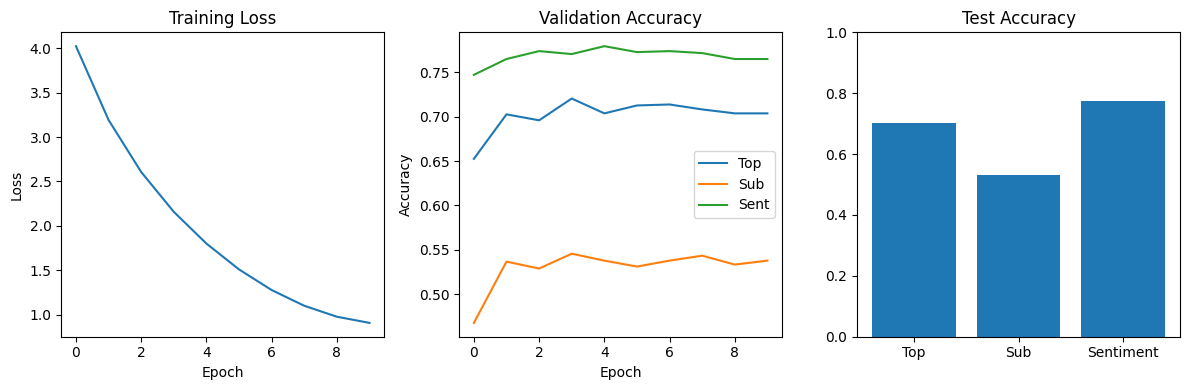

In [14]:
# Best model 로딩
model_baseline.load_state_dict(torch.load('baseline_best.pt'))

# Test
test_metrics = eval_model(model_baseline, loader_test, device)

print("\n=== Test 결과 ===")
print(f"Top Aspect Accuracy: {test_metrics['top_acc']:.4f}")
print(f"Sub Aspect Accuracy: {test_metrics['sub_acc']:.4f}")
print(f"Sentiment Accuracy: {test_metrics['sent_acc']:.4f}")

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(history['val_top_acc'], label='Top')
plt.plot(history['val_sub_acc'], label='Sub')
plt.plot(history['val_sent_acc'], label='Sent')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
metrics_names = ['Top', 'Sub', 'Sentiment']
test_scores = [test_metrics['top_acc'], test_metrics['sub_acc'], test_metrics['sent_acc']]
plt.bar(metrics_names, test_scores)
plt.title('Test Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



In [15]:
# Sub Label(Index)이 어떤 Top Label(Index)에 속하는지 1/0으로 매핑하는 행렬 생성

hierarchy_matrix = torch.zeros(num_sub, num_top)

# 유니크한 조합을 뽑아서 매핑
unique_relations = df_clean[['sub_label', 'top_label']].drop_duplicates()

for _, row in unique_relations.iterrows():
    s_idx = row['sub_label']
    t_idx = row['top_label']
    hierarchy_matrix[s_idx, t_idx] = 1.0

print(f"shape={hierarchy_matrix.shape}")

shape=torch.Size([23, 6])


## [2] hierarchical, total

### 학습 준비

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class HierarchicalModel(nn.Module):
    def __init__(self, num_top, num_sub, num_sent, hierarchy_matrix, dropout=0.3):
        super().__init__()

        # 인코더
        self.encoder = AutoModel.from_pretrained('monologg/koelectra-base-v3-discriminator')
        hidden_size = self.encoder.config.hidden_size

        # Sub, Sentiment 분류기
        self.sub_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sub)
        )

        self.sent_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sent)
        )

        # Hierarchy 정보
        self.register_buffer('hierarchy_mask', hierarchy_matrix)

        # [수정] 가중치 초기화 개선
        # 작은 양수 값으로 초기화 (학습 안정성)
        init_weights = torch.abs(torch.randn(num_sub, num_top) * 0.01) + 0.01
        self.agg_weights = nn.Parameter(init_weights)

    def forward(self, input_ids, attention_mask):
        # 인코딩
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]

        # Sub, Sentiment 예측
        sub_logits = self.sub_classifier(pooled)
        sent_logits = self.sent_classifier(pooled)

        # [핵심] Top Aspect 집계
        # 1. Sub를 확률로 변환
        sub_probs = F.softmax(sub_logits, dim=1)  # [batch, num_sub]

        # 2. 마스킹된 가중치 (연결 안 된 것은 0)
        masked_weights = self.agg_weights * self.hierarchy_mask  # [num_sub, num_top]

        # 3. 가중 합계 (Top별로 Sub들의 기여도 합산)
        top_logits_raw = torch.matmul(sub_probs, masked_weights)  # [batch, num_top]

        # 4. [수정] Softmax로 정규화 (합=1 보장)
        top_logits = F.log_softmax(top_logits_raw, dim=1)  # log_softmax가 더 안정적

        return sub_logits, sent_logits, top_logits

    def get_normalized_weights(self):
        """가중치를 Top별로 정규화해서 반환 (분석용)"""
        masked_weights = self.agg_weights.data * self.hierarchy_mask

        # Top별로 합이 1이 되도록 정규화
        #normalized = masked_weights / (masked_weights.sum(dim=0, keepdim=True) + 1e-9)
        # 수정:
        # 1. 절댓값으로 변환 (음수 방지)
        abs_weights = torch.abs(masked_weights)

        # 2. 정규화
        normalized_weights = abs_weights / (abs_weights.sum(dim=0, keepdim=True) + 1e-9)

        return normalized_weights

In [18]:
class HierarchicalModelV2(nn.Module):
    """하이브리드: 직접 분류 + 가중치 학습"""

    def __init__(self, num_top, num_sub, num_sent, hierarchy_matrix, dropout=0.3):
        super().__init__()

        self.encoder = AutoModel.from_pretrained('monologg/koelectra-base-v3-discriminator')
        hidden_size = self.encoder.config.hidden_size

        # Sub, Sentiment 분류기
        self.sub_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sub)
        )

        self.sent_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sent)
        )

        # [핵심 1] Top 직접 분류기 추가!
        self.top_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_top)
        )

        # [핵심 2] 가중치 (분석용 + 보조 학습)
        self.register_buffer('hierarchy_mask', hierarchy_matrix)
        init_weights = torch.abs(torch.randn(num_sub, num_top) * 0.01) + 0.01
        self.agg_weights = nn.Parameter(init_weights)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]

        # Sub, Sentiment 예측
        sub_logits = self.sub_classifier(pooled)
        sent_logits = self.sent_classifier(pooled)

        # [경로 1] Top 직접 예측 (메인!)
        top_logits_direct = self.top_classifier(pooled)

        # [경로 2] Top 집계 예측 (가중치 학습용!)
        sub_probs = F.softmax(sub_logits, dim=1)
        masked_weights = self.agg_weights * self.hierarchy_mask
        top_aggregated = torch.matmul(sub_probs, masked_weights)
        top_logits_agg = F.log_softmax(top_aggregated, dim=1)

        return sub_logits, sent_logits, top_logits_direct, top_logits_agg

    def get_normalized_weights(self):
        """가중치 추출 (분석용)"""
        masked_weights = self.agg_weights.data * self.hierarchy_mask
        abs_weights = torch.abs(masked_weights)
        normalized = abs_weights / (abs_weights.sum(dim=0, keepdim=True) + 1e-9)
        return normalized

In [19]:
model_hier = HierarchicalModel(num_top, num_sub, num_sent, hierarchy_matrix).to(device)

# Optimizer 재설정
optimizer = AdamW(model_hier.parameters(), lr=1e-4)
total_steps = len(loader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(loader_train) * EPOCHS)

# 작동테스트
print("\n=== 초기화 테스트 ===")
test_batch = next(iter(loader_train))
t_ids = test_batch['input_ids'].to(device)
t_mask = test_batch['attention_mask'].to(device)

with torch.no_grad():
    s_log, st_log, t_logits = model_hier(t_ids, t_mask)
    print(f"Sub Logits shape: {s_log.shape}")   # (32, num_sub)
    print(f"Top Probs shape:  {t_logits.shape}")  # (32, num_top)
    print(f"Top Probs Sample: {t_logits[0][:5]}") # 확률값 확인 (0~1 사이여야 함)


# 학습 함수 수정 (Loss 계산 변경)
def train_epoch_hierarchical(model, data_loader, optimizer, scheduler, device):
    """계층적 모델 학습 (1 epoch)"""
    model.train()
    losses = []

    # Loss 함수
    criterion_ce = nn.CrossEntropyLoss()
    criterion_nll = nn.NLLLoss()  # log_softmax 출력용

    progress_bar = tqdm(data_loader, desc='Training (Hierarchical)')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        top_labels = batch['top_label'].to(device)
        sub_labels = batch['sub_label'].to(device)
        sent_labels = batch['sent_label'].to(device)

        # Forward
        sub_logits, sent_logits, top_logits = model(input_ids, attention_mask)

        # Loss 계산
        loss_sub = criterion_ce(sub_logits, sub_labels)
        loss_sent = criterion_ce(sent_logits, sent_labels)
        loss_top = criterion_nll(top_logits, top_labels)  # log_softmax이므로 NLL

        # Loss 가중치
        loss = loss_sub + loss_sent + 2.0 * loss_top

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return np.mean(losses)

# 평가
def eval_model_hierarchical(model, data_loader, device):
    """계층적 모델 평가"""
    model.eval()

    all_top_preds, all_top_labels = [], []
    all_sub_preds, all_sub_labels = [], []
    all_sent_preds, all_sent_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 예측
            sub_logits, sent_logits, top_logits = model(input_ids, attention_mask)

            # Argmax
            sub_preds = torch.argmax(sub_logits, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()
            top_preds = torch.argmax(top_logits, dim=1).cpu().numpy()  # log_softmax도 argmax 동일

            all_top_preds.extend(top_preds)
            all_sub_preds.extend(sub_preds)
            all_sent_preds.extend(sent_preds)

            all_top_labels.extend(batch['top_label'].numpy())
            all_sub_labels.extend(batch['sub_label'].numpy())
            all_sent_labels.extend(batch['sent_label'].numpy())

    return {
        'top_acc': accuracy_score(all_top_labels, all_top_preds),
        'sub_acc': accuracy_score(all_sub_labels, all_sub_preds),
        'sent_acc': accuracy_score(all_sent_labels, all_sent_preds)
    }


=== 초기화 테스트 ===
Sub Logits shape: torch.Size([32, 23])
Top Probs shape:  torch.Size([32, 6])
Top Probs Sample: tensor([-1.7927, -1.7930, -1.7911, -1.7907, -1.7921], device='cuda:0')


In [20]:
def train_epoch_hierarchical_v3(model, data_loader, optimizer, scheduler, device):
    """하이브리드 모델 학습"""
    model.train()
    losses = []

    criterion_ce = nn.CrossEntropyLoss()
    criterion_nll = nn.NLLLoss()

    progress_bar = tqdm(data_loader, desc='Training (Hybrid)')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        top_labels = batch['top_label'].to(device)
        sub_labels = batch['sub_label'].to(device)
        sent_labels = batch['sent_label'].to(device)

        # Forward
        sub_logits, sent_logits, top_logits_direct, top_logits_agg = model(input_ids, attention_mask)

        # Loss 계산
        loss_sub = criterion_ce(sub_logits, sub_labels)
        loss_sent = criterion_ce(sent_logits, sent_labels)

        # [핵심] 두 가지 Top loss
        loss_top_direct = criterion_ce(top_logits_direct, top_labels)  # 메인
        loss_top_agg = criterion_nll(top_logits_agg, top_labels)       # 보조

        # 전체 Loss (direct가 메인, agg는 가중치 학습용)
        loss = loss_sub + loss_sent + loss_top_direct + 0.3 * loss_top_agg

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return np.mean(losses)


def eval_model_hierarchical_v3(model, data_loader, device):
    """하이브리드 모델 평가 (direct 사용)"""
    model.eval()

    all_top_preds, all_top_labels = [], []
    all_sub_preds, all_sub_labels = [], []
    all_sent_preds, all_sent_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 예측
            sub_logits, sent_logits, top_logits_direct, _ = model(input_ids, attention_mask)

            # Argmax (direct 사용!)
            sub_preds = torch.argmax(sub_logits, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()
            top_preds = torch.argmax(top_logits_direct, dim=1).cpu().numpy()  # direct!

            all_top_preds.extend(top_preds)
            all_sub_preds.extend(sub_preds)
            all_sent_preds.extend(sent_preds)

            all_top_labels.extend(batch['top_label'].numpy())
            all_sub_labels.extend(batch['sub_label'].numpy())
            all_sent_labels.extend(batch['sent_label'].numpy())

    return {
        'top_acc': accuracy_score(all_top_labels, all_top_preds),
        'sub_acc': accuracy_score(all_sub_labels, all_sub_preds),
        'sent_acc': accuracy_score(all_sent_labels, all_sent_preds)
    }

### 실행

In [21]:
#학습 실행
import time

model_hier = HierarchicalModelV2(num_top, num_sub, num_sent, hierarchy_matrix).to(device)

# 하이퍼파라미터
EPOCHS = 10
LEARNING_RATE = 1e-4

optimizer = AdamW(model_hier.parameters(), lr=LEARNING_RATE)
total_steps = len(loader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

history = {
    'train_loss': [],
    'val_top_acc': [],
    'val_sub_acc': [],
    'val_sent_acc': []
}
best_val_acc = 0.0

print("=" * 60)
print("Hierarchical Model V3 학습 (하이브리드)")
print(f"Device: {device}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print("=" * 60)

for epoch in range(EPOCHS):
    start_time = time.time()

    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss = train_epoch_hierarchical_v3(
        model_hier,
        loader_train,
        optimizer,
        scheduler,
        device
    )

    val_metrics = eval_model_hierarchical_v3(model_hier, loader_val, device)

    history['train_loss'].append(train_loss)
    history['val_top_acc'].append(val_metrics['top_acc'])
    history['val_sub_acc'].append(val_metrics['sub_acc'])
    history['val_sent_acc'].append(val_metrics['sent_acc'])

    elapsed = time.time() - start_time

    print(f"  > Train Loss: {train_loss:.4f} | Time: {elapsed:.0f}s")
    print(f"  > Valid Acc  : Top={val_metrics['top_acc']:.2%} | Sub={val_metrics['sub_acc']:.2%} | Sent={val_metrics['sent_acc']:.2%}")

    if val_metrics['top_acc'] > best_val_acc:
        best_val_acc = val_metrics['top_acc']
        torch.save(model_hier.state_dict(), 'hierarchical_best_v3.pt')
        print(f"  ★ Best Model Saved! ({best_val_acc:.2%})")

print("\n" + "=" * 60)
print(f"학습 완료! 최고 Validation Top Acc: {best_val_acc:.2%}")
print("=" * 60)

Hierarchical Model V3 학습 (하이브리드)
Device: cuda
Learning Rate: 0.0001
Epochs: 10

Epoch 1/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.22it/s]


  > Train Loss: 4.4797 | Time: 43s
  > Valid Acc  : Top=64.92% | Sub=50.00% | Sent=73.61%
  ★ Best Model Saved! (64.92%)

Epoch 2/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.38it/s]


  > Train Loss: 3.7143 | Time: 42s
  > Valid Acc  : Top=67.82% | Sub=51.45% | Sent=76.28%
  ★ Best Model Saved! (67.82%)

Epoch 3/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.35it/s]


  > Train Loss: 3.1386 | Time: 42s
  > Valid Acc  : Top=68.49% | Sub=53.34% | Sent=77.84%
  ★ Best Model Saved! (68.49%)

Epoch 4/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.44it/s]


  > Train Loss: 2.6675 | Time: 42s
  > Valid Acc  : Top=67.48% | Sub=52.12% | Sent=76.17%

Epoch 5/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.32it/s]


  > Train Loss: 2.2424 | Time: 42s
  > Valid Acc  : Top=69.60% | Sub=51.45% | Sent=77.06%
  ★ Best Model Saved! (69.60%)

Epoch 6/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.36it/s]


  > Train Loss: 1.9148 | Time: 42s
  > Valid Acc  : Top=70.49% | Sub=54.01% | Sent=75.84%
  ★ Best Model Saved! (70.49%)

Epoch 7/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.37it/s]


  > Train Loss: 1.6427 | Time: 42s
  > Valid Acc  : Top=69.38% | Sub=52.78% | Sent=76.28%

Epoch 8/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.40it/s]


  > Train Loss: 1.3902 | Time: 42s
  > Valid Acc  : Top=69.93% | Sub=52.12% | Sent=75.39%

Epoch 9/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.38it/s]


  > Train Loss: 1.2233 | Time: 42s
  > Valid Acc  : Top=69.93% | Sub=51.22% | Sent=74.72%

Epoch 10/10


Evaluating: 100%|██████████| 29/29 [00:02<00:00, 14.39it/s]

  > Train Loss: 1.1103 | Time: 42s
  > Valid Acc  : Top=68.93% | Sub=51.11% | Sent=75.06%

학습 완료! 최고 Validation Top Acc: 70.49%


In [22]:
model_hier.load_state_dict(torch.load('hierarchical_best_v3.pt'))
model_hier.eval()

# 정규화된 가중치 가져오기 (함수 사용!)
normalized_weights = model_hier.get_normalized_weights()
mask = model_hier.hierarchy_mask

print("\n=== 상위 측면별 하위 요소 기여도 분석 (전체) ===")

# Top Aspect 별로 순회하며 출력
for top_idx, top_name in top_mapping.items():
    print(f"\n[ Top Aspect: {top_name} ]")

    # 해당 Top Aspect에 속하는 Sub Aspect 찾기
    sub_indices = torch.nonzero(mask[:, top_idx]).flatten()

    if len(sub_indices) == 0:
        continue

    # 해당 Sub Aspect들의 가중치 가져오기
    sub_contributions = []
    for sub_idx in sub_indices:
        w = normalized_weights[sub_idx, top_idx].item()
        sub_name = sub_mapping[sub_idx.item()]
        sub_contributions.append((sub_name, w))

    # 기여도 높은 순으로 정렬
    sub_contributions.sort(key=lambda x: x[1], reverse=True)

    # 출력
    for name, weight in sub_contributions:
        print(f"  - {name:<20} : {weight*100:.2f}%")

# 합 확인
print("\n=== 정규화 확인 (각 Top의 합이 100%여야 함) ===")
for top_idx, top_name in top_mapping.items():
    sub_indices = torch.nonzero(mask[:, top_idx]).flatten()
    if len(sub_indices) > 0:
        total = sum([normalized_weights[s, top_idx].item() for s in sub_indices])
        print(f"{top_name}: 합={total*100:.1f}%")


=== 상위 측면별 하위 요소 기여도 분석 (전체) ===

[ Top Aspect: AUDIOVISUAL ]
  - AV_GRAPHICS          : 43.36%
  - AV_SOUND             : 29.58%
  - AV_UI_FEEL           : 27.06%

[ Top Aspect: ECONOMY_PROGRESSION ]
  - ECO_MONETIZATION     : 79.11%
  - ECO_PROGRESSION      : 16.74%
  - ECO_REWARD           : 4.15%

[ Top Aspect: GAMEPLAY ]
  - GP_CONTENT           : 28.31%
  - GP_FUN               : 27.71%
  - GP_COMBAT            : 23.21%
  - GP_CONTROL           : 20.78%

[ Top Aspect: MULTI_COMMUNITY ]
  - MULTI_FAIRNESS       : 30.30%
  - COMMUNITY_BEHAVIOR   : 24.95%
  - MULTI_SOCIAL         : 23.56%
  - MULTI_MATCHING       : 21.20%

[ Top Aspect: SYSTEM_BALANCE ]
  - SYS_RULE             : 33.02%
  - SYS_DIFFICULTY       : 26.51%
  - SYS_BALANCE          : 22.47%
  - SYS_AI               : 18.01%

[ Top Aspect: TECHNICAL ]
  - TECH_BUG             : 22.57%
  - TECH_PERFORMANCE     : 21.86%
  - TECH_LOCALIZATION    : 19.81%
  - TECH_NET             : 18.92%
  - TECH_ANTICHEAT       : 16.83%



In [23]:
# 모델 저장

import os
import shutil

files_to_save = [
    'baseline_best.pt',
    'hierarchical_best_v3.pt',
]

destination_path = '/content/drive/MyDrive'
os.makedirs(destination_path, exist_ok=True)

for file_name in files_to_save:
    if os.path.exists(file_name):
        try:
            shutil.copy(file_name, destination_path)
            print(f'{file_name} 성공')
        except Exception as e:
            print(f'{file_name} 실패')
    else:
        print(f"{file_name} 파일을 찾을 수 없음")

baseline_best.pt 성공
hierarchical_best_v3.pt 성공


## [3] hierarchical, game(app_id)별

### 학습 준비

In [24]:
game_counts = df_clean.groupby('app_id').size().sort_values(ascending=False)

# 2-Tier 분류
tier1_games = []  # 200+: 5 epoch
tier2_games = []  # <200: 3 epoch

for app_id, count in game_counts.items():
    if count >= 200:
        tier1_games.append(app_id)
    else:
        tier2_games.append(app_id)

print(f"\n[Tier 1] 200+ 리뷰 ({len(tier1_games)}개): 5 epoch")
for app_id in tier1_games:
    print(f"  - App {app_id}: {game_counts[app_id]:,}개")

print(f"\n[Tier 2] <200 리뷰 ({len(tier2_games)}개): 3 epoch")
for app_id in tier2_games:
    print(f"  - App {app_id}: {game_counts[app_id]:,}개")

# 전체 게임
all_games = tier1_games + tier2_games
total_games = len(all_games)



[Tier 1] 200+ 리뷰 (9개): 5 epoch
  - App 1086940: 2,563개
  - App 1091500: 1,878개
  - App 413150: 1,032개
  - App 578080: 797개
  - App 730: 342개
  - App 289070: 335개
  - App 1449850: 302개
  - App 227300: 285개
  - App 394360: 237개

[Tier 2] <200 리뷰 (8개): 3 epoch
  - App 3405690: 173개
  - App 489830: 169개
  - App 1222670: 169개
  - App 3450310: 159개
  - App 438100: 156개
  - App 813780: 149개
  - App 570: 144개
  - App 431960: 87개


In [25]:
#게임별 모델 학습 함수(메모리 효율 버전으로 수정)
import gc

def train_game_model(app_id, df_clean, tokenizer, device, epochs=5):

    # 메모리 정리
    torch.cuda.empty_cache()
    gc.collect()

    print(f"\n{'='*60}")
    print(f"App ID {app_id} - {game_counts[app_id]:,}개 리뷰 ({epochs} epochs)")
    print(f"GPU 메모리: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"{'='*60}")

    # 데이터 필터링
    game_df = df_clean[df_clean['app_id'] == app_id].copy().reset_index(drop=True)

    # 클래스 분포 확인
    top_dist = game_df['top_label'].value_counts()
    if len(top_dist) < 2:
        print('단일 클래스')
        return None

    # Train/Val 분할
    try:
        game_train, game_val = train_test_split(
            game_df, test_size=0.2, random_state=42,
            stratify=game_df['top_label']
        )
    except:
        print("  (stratify 불가 → random split)")
        game_train, game_val = train_test_split(
            game_df, test_size=0.2, random_state=42
        )

    game_train = game_train.reset_index(drop=True)
    game_val = game_val.reset_index(drop=True)

    print(f"  Train: {len(game_train)}, Val: {len(game_val)}")

    # === Batch size 줄이기 (중요!) ===
    batch_size = 8  # 16 → 8

    # Dataset & Loader
    dataset_train_game = ReviewDataset(game_train, tokenizer)
    dataset_val_game = ReviewDataset(game_val, tokenizer)

    loader_train_game = DataLoader(dataset_train_game, batch_size=batch_size, shuffle=True)
    loader_val_game = DataLoader(dataset_val_game, batch_size=batch_size, shuffle=False)

    # Hierarchy Matrix
    hierarchy_matrix_game = torch.zeros(num_sub, num_top)
    unique_relations = game_df[['sub_label', 'top_label']].drop_duplicates()
    for _, row in unique_relations.iterrows():
        hierarchy_matrix_game[row['sub_label'], row['top_label']] = 1.0

    # 모델 생성
    model_game = HierarchicalModel(
        num_top, num_sub, num_sent,
        hierarchy_matrix_game
    ).to(device)

    # Optimizer
    optimizer = AdamW(model_game.parameters(), lr=1e-4)
    total_steps = len(loader_train_game) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

    # 학습
    best_acc = 0
    start_time = time.time()

    for epoch in range(epochs):
        train_loss = train_epoch_hierarchical(
            model_game, loader_train_game, optimizer, scheduler, device
        )

        val_metrics = eval_model_hierarchical(model_game, loader_val_game, device)

        print(f"  Epoch {epoch+1}/{epochs} | "
              f"Loss: {train_loss:.3f} | "
              f"Top: {val_metrics['top_acc']:.1%}")

        if val_metrics['top_acc'] > best_acc:
            best_acc = val_metrics['top_acc']
            torch.save(model_game.state_dict(), f'game_{app_id}_best.pt')

    elapsed = time.time() - start_time
    print(f"  ✓ 완료! Best: {best_acc:.1%} ({elapsed:.0f}초)")

    # Best model 로딩
    model_game.load_state_dict(torch.load(f'game_{app_id}_best.pt'))

    # === 모델 CPU로 이동 (메모리 절약!) ===
    model_game = model_game.cpu()

    return model_game

In [26]:
#가중치 추출
def extract_game_weights(model, top_mapping, sub_mapping):

    model.eval()
    normalized_weights = model.get_normalized_weights()

    game_weights = {}

    for top_idx, top_name in top_mapping.items():
        game_weights[top_name] = {}

        sub_indices = torch.nonzero(model.hierarchy_mask[:, top_idx]).flatten()

        for sub_idx in sub_indices:
            sub_name = sub_mapping[sub_idx.item()]
            weight = normalized_weights[sub_idx, top_idx].item()
            game_weights[top_name][sub_name] = weight

    return game_weights

### 실행

In [27]:
# #게임 학습 실행
# game_models = {}
# game_weights = {}
# failed_games = []

# print("\n" + "=" * 60)
# print("게임별 학습 시작")
# print("=" * 60)

# total_start = time.time()

# # Tier 1: 5 epochs
# for i, app_id in enumerate(tier1_games, 1):
#     print(f"\n[Tier 1: {i}/{len(tier1_games)}]")
#     try:
#         model = train_game_model(app_id, df_clean, tokenizer, device, epochs=5)
#         if model:
#             weights = extract_game_weights(model, top_mapping, sub_mapping)
#             game_models[app_id] = model
#             game_weights[app_id] = weights
#     except Exception as e:
#         print(f"실패: {str(e)[:100]}")
#         failed_games.append(app_id)

# # Tier 2: 3 epochs
# for i, app_id in enumerate(tier2_games, 1):
#     print(f"\n[Tier 2: {i}/{len(tier2_games)}]")
#     try:
#         model = train_game_model(app_id, df_clean, tokenizer, device, epochs=3)
#         if model:
#             weights = extract_game_weights(model, top_mapping, sub_mapping)
#             game_models[app_id] = model
#             game_weights[app_id] = weights
#     except Exception as e:
#         print(f"실패: {str(e)[:100]}")
#         failed_games.append(app_id)

# total_elapsed = time.time() - total_start

# print("\n" + "=" * 60)
# print("게임별 학습 완료!")
# print("=" * 60)
# print(f"성공: {len(game_models)}개")
# print(f"실패: {len(failed_games)}개")
# if failed_games:
#     print(f"실패 목록: {failed_games}")
# print(f"총 소요 시간: {total_elapsed/60:.1f}분")

### 런타임 오류로 인한 변수 복구
[문제]
- 위 셀이 실행되다가 완료되지 못한 상태로 런타임이 날아가버렸다.(RAM 문제 추정)

[상황]
- 일부 게임은 학습 완료되었으나 drive에 저장되지 않음😭
- 변수 모두 초기화됨

[해결방안 후보]
- 1) 처음부터 전체 재실행할 경우, 리소스가 많이 소요된다.
- 2) 기존 셀의 일부만 재실행할 경우, 셀 내의 일부만 재실행 대상일 경우 꼬일 여지가 있다.
- 3) **[최종선택]** 별도의 복구 코드를 작성하여 필요한 변수들을 가져온다. 핵심은 게임별 학습 및 가중치 가져오는 부분만 재실행하면 된다는 것이다.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import time
import gc
import os
import glob

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# 데이터 로드
df_annotated = pd.read_csv('/content/drive/MyDrive/annotated_sampled_fn.csv', index_col = 0)
# 필요한 컬럼만 선택
df_annotated = df_annotated[['app_id', 'sentence', 'top_aspect', 'sub_aspect', 'sentiment']].copy()
# other 제거
df_clean = df_annotated[df_annotated['top_aspect'] != 'OTHER'].copy()

print(df_clean['app_id'].value_counts())

app_id
1086940    2571
1091500    1883
413150     1036
578080      802
730         342
289070      337
1449850     305
227300      287
394360      237
3405690     173
489830      170
1222670     169
3450310     162
438100      157
813780      149
570         144
431960       87
Name: count, dtype: int64


In [30]:
#10개 미만 sub_aspect 삭제
sub_counts = df_clean['sub_aspect'].value_counts()
valid_sub_aspects = sub_counts[sub_counts >= 10].index
df_clean = df_clean[df_clean['sub_aspect'].isin(valid_sub_aspects)].copy()

In [31]:
print(df_clean['top_aspect'].value_counts())
print('\n', df_clean['sub_aspect'].value_counts())

top_aspect
GAMEPLAY               5161
TECHNICAL              1551
SYSTEM_BALANCE          708
MULTI_COMMUNITY         665
ECONOMY_PROGRESSION     458
AUDIOVISUAL             434
Name: count, dtype: int64

 sub_aspect
GP_FUN                3244
GP_CONTENT            1742
TECH_BUG               894
ECO_MONETIZATION       399
SYS_DIFFICULTY         368
TECH_PERFORMANCE       304
MULTI_FAIRNESS         290
MULTI_SOCIAL           278
AV_GRAPHICS            259
TECH_LOCALIZATION      204
SYS_RULE               193
GP_COMBAT              130
AV_SOUND               106
SYS_BALANCE             86
TECH_NET                81
AV_UI_FEEL              69
TECH_ANTICHEAT          68
SYS_AI                  61
COMMUNITY_BEHAVIOR      55
ECO_PROGRESSION         45
GP_CONTROL              45
MULTI_MATCHING          42
ECO_REWARD              14
Name: count, dtype: int64


In [32]:
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder

le_top = LabelEncoder()
le_sub = LabelEncoder()
le_sent = LabelEncoder()

df_clean['top_label'] = le_top.fit_transform(df_clean['top_aspect'])
df_clean['sub_label'] = le_sub.fit_transform(df_clean['sub_aspect'])
df_clean['sent_label'] = le_sent.fit_transform(df_clean['sentiment'])

# 매핑 저장
top_mapping = dict(enumerate(le_top.classes_))
sub_mapping = dict(enumerate(le_sub.classes_))
sent_mapping = dict(enumerate(le_sent.classes_))

print("\n=== 라벨 매핑 ===")
print(f"Top aspects: {len(top_mapping)}개")
print(top_mapping)
print(f"\nSub aspects: {len(sub_mapping)}개")
print(sub_mapping)
print(f"\nSentiment: {sent_mapping}")

# 클래스 개수
num_top = len(top_mapping)
num_sub = len(sub_mapping)
num_sent = len(sent_mapping)

print(f"\n분류 클래스 수: Top={num_top}, Sub={num_sub}, Sent={num_sent}")


=== 라벨 매핑 ===
Top aspects: 6개
{0: 'AUDIOVISUAL', 1: 'ECONOMY_PROGRESSION', 2: 'GAMEPLAY', 3: 'MULTI_COMMUNITY', 4: 'SYSTEM_BALANCE', 5: 'TECHNICAL'}

Sub aspects: 23개
{0: 'AV_GRAPHICS', 1: 'AV_SOUND', 2: 'AV_UI_FEEL', 3: 'COMMUNITY_BEHAVIOR', 4: 'ECO_MONETIZATION', 5: 'ECO_PROGRESSION', 6: 'ECO_REWARD', 7: 'GP_COMBAT', 8: 'GP_CONTENT', 9: 'GP_CONTROL', 10: 'GP_FUN', 11: 'MULTI_FAIRNESS', 12: 'MULTI_MATCHING', 13: 'MULTI_SOCIAL', 14: 'SYS_AI', 15: 'SYS_BALANCE', 16: 'SYS_DIFFICULTY', 17: 'SYS_RULE', 18: 'TECH_ANTICHEAT', 19: 'TECH_BUG', 20: 'TECH_LOCALIZATION', 21: 'TECH_NET', 22: 'TECH_PERFORMANCE'}

Sentiment: {0: 'negative', 1: 'neutral', 2: 'positive'}

분류 클래스 수: Top=6, Sub=23, Sent=3


In [33]:
# 토크나이저
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')

# Hierarchy Matrix
hierarchy_matrix = torch.zeros(num_sub, num_top)
unique_relations = df_clean[['sub_label', 'top_label']].drop_duplicates()
for _, row in unique_relations.iterrows():
    hierarchy_matrix[row['sub_label'], row['top_label']] = 1.0

# 저장 (다음을 위해)
import pickle
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({
        'le_top': le_top,
        'le_sub': le_sub,
        'le_sent': le_sent,
        'top_mapping': top_mapping,
        'sub_mapping': sub_mapping,
        'sent_mapping': sent_mapping,
        'num_top': num_top,
        'num_sub': num_sub,
        'num_sent': num_sent
    }, f)

In [34]:
# 게임 분류
game_counts = df_clean.groupby('app_id').size().sort_values(ascending=False)

tier1_games = []  # 200+
tier2_games = []  # <200

for app_id, count in game_counts.items():
    if count >= 200:
        tier1_games.append(app_id)
    else:
        tier2_games.append(app_id)

print(f"전체 게임: {len(game_counts)}개")
print(f"  Tier 1 (200+): {len(tier1_games)}개")
print(f"  Tier 2 (<200): {len(tier2_games)}개")

전체 게임: 17개
  Tier 1 (200+): 9개
  Tier 2 (<200): 8개


In [35]:
# Dataset 클래스
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        encoding = self.tokenizer(
            row['sentence'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'top_label': torch.tensor(row['top_label'], dtype=torch.long),
            'sub_label': torch.tensor(row['sub_label'], dtype=torch.long),
            'sent_label': torch.tensor(row['sent_label'], dtype=torch.long)
        }


# 모델 클래스
class HierarchicalModel(nn.Module):
    def __init__(self, num_top, num_sub, num_sent, hierarchy_matrix, dropout=0.3):
        super().__init__()

        self.encoder = AutoModel.from_pretrained('monologg/koelectra-base-v3-discriminator')
        hidden_size = self.encoder.config.hidden_size

        self.sub_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sub)
        )

        self.sent_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sent)
        )

        self.register_buffer('hierarchy_mask', hierarchy_matrix)
        init_weights = torch.abs(torch.randn(num_sub, num_top) * 0.01) + 0.01
        self.agg_weights = nn.Parameter(init_weights)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]

        sub_logits = self.sub_classifier(pooled)
        sent_logits = self.sent_classifier(pooled)

        sub_probs = F.softmax(sub_logits, dim=1)
        masked_weights = self.agg_weights * self.hierarchy_mask
        top_logits_raw = torch.matmul(sub_probs, masked_weights)
        top_logits = F.log_softmax(top_logits_raw, dim=1)

        return sub_logits, sent_logits, top_logits

    def get_normalized_weights(self):
        masked_weights = self.agg_weights.data * self.hierarchy_mask
        abs_weights = torch.abs(masked_weights)
        normalized = abs_weights / (abs_weights.sum(dim=0, keepdim=True) + 1e-9)
        return normalized

In [36]:
# 학습 함수
def train_epoch_hierarchical(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []

    criterion_ce = nn.CrossEntropyLoss()
    criterion_nll = nn.NLLLoss()

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        top_labels = batch['top_label'].to(device)
        sub_labels = batch['sub_label'].to(device)
        sent_labels = batch['sent_label'].to(device)

        sub_logits, sent_logits, top_logits = model(input_ids, attention_mask)

        loss_sub = criterion_ce(sub_logits, sub_labels)
        loss_sent = criterion_ce(sent_logits, sent_labels)
        loss_top = criterion_nll(top_logits, top_labels)

        loss = 2.0 * loss_sub + loss_sent + loss_top

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

    return np.mean(losses)


# 평가 함수
def eval_model_hierarchical(model, data_loader, device):
    model.eval()

    all_top_preds, all_top_labels = [], []
    all_sub_preds, all_sub_labels = [], []
    all_sent_preds, all_sent_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            sub_logits, sent_logits, top_logits = model(input_ids, attention_mask)

            sub_preds = torch.argmax(sub_logits, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()
            top_preds = torch.argmax(top_logits, dim=1).cpu().numpy()

            all_top_preds.extend(top_preds)
            all_sub_preds.extend(sub_preds)
            all_sent_preds.extend(sent_preds)

            all_top_labels.extend(batch['top_label'].numpy())
            all_sub_labels.extend(batch['sub_label'].numpy())
            all_sent_labels.extend(batch['sent_label'].numpy())

    return {
        'top_acc': accuracy_score(all_top_labels, all_top_preds),
        'sub_acc': accuracy_score(all_sub_labels, all_sub_preds),
        'sent_acc': accuracy_score(all_sent_labels, all_sent_preds)
    }


# 게임별 가중치 추출
def extract_game_weights(model, top_mapping, sub_mapping):
    model.eval()
    normalized_weights = model.get_normalized_weights()

    game_weights = {}

    for top_idx, top_name in top_mapping.items():
        game_weights[top_name] = {}
        sub_indices = torch.nonzero(model.hierarchy_mask[:, top_idx]).flatten()

        for sub_idx in sub_indices:
            sub_name = sub_mapping[sub_idx.item()]
            weight = normalized_weights[sub_idx, top_idx].item()
            game_weights[top_name][sub_name] = weight

    return game_weights



In [37]:
import psutil

# RAM 폭주 방지 버전

# Google Drive 경로
DRIVE_PATH = '/content/drive/MyDrive/game_models'
os.makedirs(DRIVE_PATH, exist_ok=True)

# 게임별 학습 함수 (동일)
def train_game_model_safe(app_id, df_clean, tokenizer, device, epochs=5):

    torch.cuda.empty_cache()
    gc.collect()

    print(f"\n{'='*60}")
    print(f"App ID {app_id} - {game_counts[app_id]:,}개 리뷰")
    print(f"RAM: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")  # RAM 모니터링
    print(f"GPU: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"{'='*60}")

    game_df = df_clean[df_clean['app_id'] == app_id].copy().reset_index(drop=True)

    if game_df['top_label'].nunique() < 2:
        print("Skip")
        return None

    try:
        game_train, game_val = train_test_split(
            game_df, test_size=0.2, random_state=42, stratify=game_df['top_label']
        )
    except:
        game_train, game_val = train_test_split(game_df, test_size=0.2, random_state=42)

    game_train = game_train.reset_index(drop=True)
    game_val = game_val.reset_index(drop=True)

    # 작은 배치
    batch_size = 4

    dataset_train_game = ReviewDataset(game_train, tokenizer)
    dataset_val_game = ReviewDataset(game_val, tokenizer)
    loader_train_game = DataLoader(dataset_train_game, batch_size=batch_size, shuffle=True)
    loader_val_game = DataLoader(dataset_val_game, batch_size=batch_size, shuffle=False)

    # Hierarchy matrix
    hierarchy_matrix_game = torch.zeros(num_sub, num_top)
    unique_relations = game_df[['sub_label', 'top_label']].drop_duplicates()
    for _, row in unique_relations.iterrows():
        hierarchy_matrix_game[row['sub_label'], row['top_label']] = 1.0

    # 모델
    model_game = HierarchicalModel(num_top, num_sub, num_sent, hierarchy_matrix_game).to(device)

    optimizer = AdamW(model_game.parameters(), lr=1e-4)
    total_steps = len(loader_train_game) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

    # 학습
    best_acc = 0

    for epoch in range(epochs):
        train_loss = train_epoch_hierarchical(model_game, loader_train_game, optimizer, scheduler, device)
        val_metrics = eval_model_hierarchical(model_game, loader_val_game, device)

        print(f"  Epoch {epoch+1}/{epochs} | Loss: {train_loss:.3f} | Top: {val_metrics['top_acc']:.1%}")

        if val_metrics['top_acc'] > best_acc:
            best_acc = val_metrics['top_acc']
            # Drive에 저장
            save_path = f'{DRIVE_PATH}/game_{app_id}_best.pt'
            torch.save(model_game.state_dict(), save_path)

    print(f"  ✓ Best: {best_acc:.1%}")

    # Best model 로드
    model_game.load_state_dict(torch.load(f'{DRIVE_PATH}/game_{app_id}_best.pt'))

    # [RAM 폭주 방지] 가중치 추출 (GPU에서)
    model_game.eval()
    weights = extract_game_weights(model_game, top_mapping, sub_mapping)

    # [RAM 폭주 방지] 모델 완전히 삭제
    del model_game, optimizer, scheduler
    del loader_train_game, loader_val_game
    del dataset_train_game, dataset_val_game
    del game_train, game_val, game_df

    # 강제 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

    # 가중치만 반환 (모델 반환 안 함!)
    return weights


In [38]:
# [RAM 폭주 방지] 모델은 저장 안 함!
game_weights = {}
failed_games = []

# [RAM 폭주 방지] 주기적 저장 & 메모리 비우기
SAVE_INTERVAL = 3  # 3개마다 저장하고 비우기
CHECKPOINT_PATH = f'{DRIVE_PATH}/game_weights_checkpoint.pkl'

print("=" * 60)
print("게임별 학습 시작 (메모리 안전 모드)")
print("=" * 60)

# Tier 1
for i, app_id in enumerate(tier1_games, 1):
    print(f"\n[Tier 1: {i}/{len(tier1_games)}]")

    try:
        # 가중치만 받음 (모델은 안 받음)
        weights = train_game_model_safe(app_id, df_clean, tokenizer, device, epochs=5)

        if weights:
            game_weights[app_id] = weights

            # [RAM 폭주 방지] 주기적 저장 & 메모리 비우기
            if i % SAVE_INTERVAL == 0:
                # 파일로 저장
                with open(CHECKPOINT_PATH, 'wb') as f:
                    pickle.dump(game_weights, f)

                print(f"\n 체크포인트 저장 (완료: {len(game_weights)}개)")
                print(f"  RAM: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")

                # [RAM 폭주 방지] 메모리 비우기
                # 너무 많이 쌓이면 오래된 것 삭제
                if len(game_weights) > 10:
                    # 가장 오래된 5개 삭제
                    old_keys = list(game_weights.keys())[:5]
                    for key in old_keys:
                        del game_weights[key]
                    print(f"메모리 정리 (남은 가중치: {len(game_weights)}개)")
                    gc.collect()

    except Exception as e:
        print(f"{str(e)[:100]}")
        failed_games.append(app_id)
        if "out of memory" in str(e).lower():
            gc.collect()
            torch.cuda.empty_cache()

# Tier 2
for i, app_id in enumerate(tier2_games, 1):
    print(f"\n[Tier 2: {i}/{len(tier2_games)}]")

    try:
        weights = train_game_model_safe(app_id, df_clean, tokenizer, device, epochs=3)

        if weights:
            game_weights[app_id] = weights

            if i % SAVE_INTERVAL == 0:
                with open(CHECKPOINT_PATH, 'wb') as f:
                    pickle.dump(game_weights, f)

                print(f"\n체크포인트 저장 (완료: {len(game_weights)}개)")
                print(f"RAM: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")

                # 메모리 비우기
                if len(game_weights) > 10:
                    old_keys = list(game_weights.keys())[:5]
                    for key in old_keys:
                        del game_weights[key]
                    print(f"메모리 정리")
                    gc.collect()

    except Exception as e:
        print(f"{str(e)[:100]}")
        failed_games.append(app_id)
        if "out of memory" in str(e).lower():
            gc.collect()
            torch.cuda.empty_cache()

# 최종 저장
with open(f'{DRIVE_PATH}/game_weights_final.pkl', 'wb') as f:
    pickle.dump(game_weights, f)

print("\n" + "=" * 60)
print(f"성공: {len(game_weights) + (len(tier1_games) + len(tier2_games) - len(game_weights) - len(failed_games))}개")
print(f"실패: {len(failed_games)}개")

게임별 학습 시작 (메모리 안전 모드)

[Tier 1: 1/9]

App ID 1086940 - 2,563개 리뷰
RAM: 2.65 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 129/129 [00:01<00:00, 76.28it/s]


  Epoch 1/5 | Loss: 6.478 | Top: 70.6%


Evaluating: 100%|██████████| 129/129 [00:01<00:00, 76.53it/s]


  Epoch 2/5 | Loss: 6.386 | Top: 70.6%


Evaluating: 100%|██████████| 129/129 [00:01<00:00, 72.64it/s]


  Epoch 3/5 | Loss: 6.340 | Top: 70.6%


Evaluating: 100%|██████████| 129/129 [00:01<00:00, 76.45it/s]


  Epoch 4/5 | Loss: 6.330 | Top: 70.6%


Evaluating: 100%|██████████| 129/129 [00:01<00:00, 78.06it/s]


  Epoch 5/5 | Loss: 6.312 | Top: 70.6%
  ✓ Best: 70.6%

[Tier 1: 2/9]

App ID 1091500 - 1,878개 리뷰
RAM: 2.66 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 76.69it/s]


  Epoch 1/5 | Loss: 6.960 | Top: 53.7%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 76.99it/s]


  Epoch 2/5 | Loss: 6.814 | Top: 53.7%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 75.79it/s]


  Epoch 3/5 | Loss: 6.760 | Top: 53.7%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 76.92it/s]


  Epoch 4/5 | Loss: 6.770 | Top: 53.7%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 77.13it/s]


  Epoch 5/5 | Loss: 6.744 | Top: 53.7%
  ✓ Best: 53.7%

[Tier 1: 3/9]

App ID 413150 - 1,032개 리뷰
RAM: 2.66 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 52/52 [00:00<00:00, 77.93it/s]


  Epoch 1/5 | Loss: 5.583 | Top: 79.2%


Evaluating: 100%|██████████| 52/52 [00:00<00:00, 75.51it/s]


  Epoch 2/5 | Loss: 5.391 | Top: 79.2%


Evaluating: 100%|██████████| 52/52 [00:00<00:00, 77.27it/s]


  Epoch 3/5 | Loss: 5.347 | Top: 79.2%


Evaluating: 100%|██████████| 52/52 [00:00<00:00, 73.71it/s]


  Epoch 4/5 | Loss: 5.347 | Top: 79.2%


Evaluating: 100%|██████████| 52/52 [00:00<00:00, 75.61it/s]


  Epoch 5/5 | Loss: 5.333 | Top: 79.2%
  ✓ Best: 79.2%

 체크포인트 저장 (완료: 3개)
  RAM: 2.68 GB

[Tier 1: 4/9]

App ID 578080 - 797개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 78.96it/s]


  Epoch 1/5 | Loss: 7.518 | Top: 36.9%


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 76.72it/s]


  Epoch 2/5 | Loss: 7.336 | Top: 36.9%


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.17it/s]


  Epoch 3/5 | Loss: 7.308 | Top: 36.9%


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.27it/s]


  Epoch 4/5 | Loss: 7.300 | Top: 36.9%


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 76.22it/s]


  Epoch 5/5 | Loss: 7.274 | Top: 36.9%
  ✓ Best: 36.9%

[Tier 1: 5/9]

App ID 730 - 342개 리뷰
RAM: 2.82 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 72.95it/s]


  Epoch 1/5 | Loss: 7.708 | Top: 37.7%


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 75.09it/s]


  Epoch 2/5 | Loss: 7.103 | Top: 49.3%


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 74.67it/s]


  Epoch 3/5 | Loss: 6.453 | Top: 53.6%


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 77.22it/s]


  Epoch 4/5 | Loss: 5.535 | Top: 56.5%


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 78.41it/s]


  Epoch 5/5 | Loss: 4.978 | Top: 56.5%
  ✓ Best: 56.5%

[Tier 1: 6/9]

App ID 289070 - 335개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 77.22it/s]


  Epoch 1/5 | Loss: 7.011 | Top: 61.2%


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 76.34it/s]


  Epoch 2/5 | Loss: 6.599 | Top: 61.2%


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 77.57it/s]


  Epoch 3/5 | Loss: 6.620 | Top: 61.2%


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 76.84it/s]


  Epoch 4/5 | Loss: 6.558 | Top: 61.2%


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 78.69it/s]


  Epoch 5/5 | Loss: 6.563 | Top: 61.2%
  ✓ Best: 61.2%

 체크포인트 저장 (완료: 6개)
  RAM: 2.68 GB

[Tier 1: 7/9]

App ID 1449850 - 302개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 75.32it/s]


  Epoch 1/5 | Loss: 7.899 | Top: 39.3%


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 76.08it/s]


  Epoch 2/5 | Loss: 7.516 | Top: 39.3%


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 74.49it/s]


  Epoch 3/5 | Loss: 7.362 | Top: 39.3%


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 77.14it/s]


  Epoch 4/5 | Loss: 6.853 | Top: 49.2%


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 76.48it/s]


  Epoch 5/5 | Loss: 6.262 | Top: 50.8%
  ✓ Best: 50.8%

[Tier 1: 8/9]

App ID 227300 - 285개 리뷰
RAM: 2.72 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 79.04it/s]


  Epoch 1/5 | Loss: 6.913 | Top: 64.9%


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 68.80it/s]


  Epoch 2/5 | Loss: 6.343 | Top: 64.9%


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 79.08it/s]


  Epoch 3/5 | Loss: 6.304 | Top: 64.9%


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 76.81it/s]


  Epoch 4/5 | Loss: 6.317 | Top: 64.9%


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 78.76it/s]


  Epoch 5/5 | Loss: 6.281 | Top: 64.9%
  ✓ Best: 64.9%

[Tier 1: 9/9]

App ID 394360 - 237개 리뷰
RAM: 2.72 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 77.81it/s]


  Epoch 1/5 | Loss: 7.777 | Top: 50.0%


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 77.10it/s]


  Epoch 2/5 | Loss: 7.087 | Top: 50.0%


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 75.91it/s]


  Epoch 3/5 | Loss: 6.315 | Top: 56.2%


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 72.69it/s]


  Epoch 4/5 | Loss: 5.322 | Top: 56.2%


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 77.46it/s]


  Epoch 5/5 | Loss: 4.761 | Top: 58.3%
  ✓ Best: 58.3%

 체크포인트 저장 (완료: 9개)
  RAM: 2.68 GB

[Tier 2: 1/8]

App ID 3405690 - 173개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 75.55it/s]


  Epoch 1/3 | Loss: 8.040 | Top: 40.0%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 76.10it/s]


  Epoch 2/3 | Loss: 7.368 | Top: 40.0%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 76.06it/s]


  Epoch 3/3 | Loss: 7.100 | Top: 40.0%
  ✓ Best: 40.0%

[Tier 2: 2/8]

App ID 489830 - 169개 리뷰
RAM: 2.99 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 76.78it/s]


  Epoch 1/3 | Loss: 7.308 | Top: 67.6%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 77.57it/s]


  Epoch 2/3 | Loss: 6.178 | Top: 67.6%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 72.09it/s]


  Epoch 3/3 | Loss: 5.643 | Top: 67.6%
  ✓ Best: 67.6%

[Tier 2: 3/8]

App ID 1222670 - 169개 리뷰
RAM: 2.99 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 78.00it/s]


  Epoch 1/3 | Loss: 7.750 | Top: 44.1%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 78.44it/s]


  Epoch 2/3 | Loss: 6.960 | Top: 44.1%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 77.01it/s]


  Epoch 3/3 | Loss: 6.461 | Top: 44.1%
  ✓ Best: 44.1%

체크포인트 저장 (완료: 12개)
RAM: 2.68 GB
메모리 정리

[Tier 2: 4/8]

App ID 3450310 - 159개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 72.45it/s]


  Epoch 1/3 | Loss: 8.217 | Top: 50.0%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 73.45it/s]


  Epoch 2/3 | Loss: 7.461 | Top: 50.0%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 76.84it/s]


  Epoch 3/3 | Loss: 7.360 | Top: 50.0%
  ✓ Best: 50.0%

[Tier 2: 5/8]

App ID 438100 - 156개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 76.54it/s]


  Epoch 1/3 | Loss: 7.614 | Top: 40.6%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 71.65it/s]


  Epoch 2/3 | Loss: 6.843 | Top: 40.6%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 65.67it/s]


  Epoch 3/3 | Loss: 6.422 | Top: 40.6%
  ✓ Best: 40.6%

[Tier 2: 6/8]

App ID 813780 - 149개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 77.18it/s]


  Epoch 1/3 | Loss: 7.974 | Top: 50.0%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 74.72it/s]


  Epoch 2/3 | Loss: 7.072 | Top: 50.0%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 76.03it/s]


  Epoch 3/3 | Loss: 6.712 | Top: 50.0%
  ✓ Best: 50.0%

체크포인트 저장 (완료: 10개)
RAM: 2.68 GB

[Tier 2: 7/8]

App ID 570 - 144개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 80.14it/s]


  Epoch 1/3 | Loss: 8.302 | Top: 34.5%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 79.87it/s]


  Epoch 2/3 | Loss: 7.775 | Top: 34.5%


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 77.24it/s]


  Epoch 3/3 | Loss: 7.560 | Top: 34.5%
  ✓ Best: 34.5%

[Tier 2: 8/8]

App ID 431960 - 87개 리뷰
RAM: 2.68 GB
GPU: 2.61 GB


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 78.96it/s]


  Epoch 1/3 | Loss: 8.181 | Top: 33.3%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 78.66it/s]


  Epoch 2/3 | Loss: 6.948 | Top: 33.3%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 78.42it/s]


  Epoch 3/3 | Loss: 6.503 | Top: 33.3%
  ✓ Best: 33.3%

성공: 17개
실패: 0개


In [39]:
# 실패한 게임 하나만 재실행

app_id = 1222670

print(f"App {app_id} 재실행 중...")

try:
    torch.cuda.empty_cache()
    gc.collect()

    game_df = df_clean[df_clean['app_id'] == app_id].copy().reset_index(drop=True)

    game_train, game_val = train_test_split(game_df, test_size=0.2, random_state=42, stratify=game_df['top_label'])
    game_train = game_train.reset_index(drop=True)
    game_val = game_val.reset_index(drop=True)

    batch_size = 4
    dataset_train_game = ReviewDataset(game_train, tokenizer)
    dataset_val_game = ReviewDataset(game_val, tokenizer)
    loader_train_game = DataLoader(dataset_train_game, batch_size=batch_size, shuffle=True)
    loader_val_game = DataLoader(dataset_val_game, batch_size=batch_size, shuffle=False)

    hierarchy_matrix_game = torch.zeros(num_sub, num_top)
    unique_relations = game_df[['sub_label', 'top_label']].drop_duplicates()
    for _, row in unique_relations.iterrows():
        hierarchy_matrix_game[row['sub_label'], row['top_label']] = 1.0

    model_game = HierarchicalModel(num_top, num_sub, num_sent, hierarchy_matrix_game).to(device)

    optimizer = AdamW(model_game.parameters(), lr=1e-4)
    total_steps = len(loader_train_game) * 3
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

    best_acc = 0

    for epoch in range(3):
        train_loss = train_epoch_hierarchical(model_game, loader_train_game, optimizer, scheduler, device)
        val_metrics = eval_model_hierarchical(model_game, loader_val_game, device)

        print(f"  Epoch {epoch+1}/3 | Loss: {train_loss:.3f} | Top: {val_metrics['top_acc']:.1%}")

        if val_metrics['top_acc'] > best_acc:
            best_acc = val_metrics['top_acc']
            save_path = f'{DRIVE_PATH}/game_{app_id}_best.pt'
            torch.save(model_game.state_dict(), save_path)

    print(f"  ✓ Best: {best_acc:.1%}")

    # [수정] 로드 안 하고 바로 가중치 추출
    model_game.eval()
    weights = extract_game_weights(model_game, top_mapping, sub_mapping)

    # game_weights에 추가
    game_weights[app_id] = weights

    print(f"App {app_id} 완료!")

    # 정리
    del model_game, optimizer, scheduler
    gc.collect()
    torch.cuda.empty_cache()

except Exception as e:
    print(f"실패: {e}")

App 1222670 재실행 중...


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 77.92it/s]


  Epoch 1/3 | Loss: 7.829 | Top: 44.1%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 76.86it/s]


  Epoch 2/3 | Loss: 7.092 | Top: 44.1%


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 75.75it/s]


  Epoch 3/3 | Loss: 7.068 | Top: 44.1%
  ✓ Best: 44.1%
App 1222670 완료!


In [40]:
#가중치 복구 필요

DRIVE_PATH = '/content/drive/MyDrive/game_models'

# Drive에 있는 모든 게임 모델 찾기
saved_files = glob.glob(f'{DRIVE_PATH}/game_*_best.pt')

print(f"Drive에서 발견된 게임 모델: {len(saved_files)}개")

# 파일명에서 app_id 추출
saved_app_ids = []
for file in saved_files:
    # 파일명: .../game_1086940_best.pt
    filename = os.path.basename(file)
    app_id = int(filename.replace('game_', '').replace('_best.pt', ''))
    saved_app_ids.append(app_id)

saved_app_ids.sort()

print(f"\n발견된 게임:")
for app_id in saved_app_ids:
    count = game_counts[app_id]
    tier = "Tier 1" if count >= 200 else "Tier 2"
    print(f"  - App {app_id}: {count}개 ({tier})")

# 가중치 복구 함수
def load_game_weights_from_drive(app_id):
    """Drive에 저장된 모델에서 가중치 복구"""

    game_df = df_clean[df_clean['app_id'] == app_id]

    # Hierarchy matrix 재생성
    hierarchy_matrix_game = torch.zeros(num_sub, num_top)
    unique_relations = game_df[['sub_label', 'top_label']].drop_duplicates()
    for _, row in unique_relations.iterrows():
        hierarchy_matrix_game[row['sub_label'], row['top_label']] = 1.0

    # 모델 생성 & 로드
    model = HierarchicalModel(num_top, num_sub, num_sent, hierarchy_matrix_game)
    model.load_state_dict(torch.load(f'{DRIVE_PATH}/game_{app_id}_best.pt', map_location='cpu'))
    model.eval()

    # 가중치 추출
    weights = extract_game_weights(model, top_mapping, sub_mapping)

    del model
    gc.collect()

    return weights

# 전체 복구
print("\n가중치 복구 중...")
game_weights = {}

for i, app_id in enumerate(saved_app_ids, 1):
    try:
        weights = load_game_weights_from_drive(app_id)
        game_weights[app_id] = weights
        print(f"  [{i}/{len(saved_app_ids)}] App {app_id} ✓")
    except Exception as e:
        print(f"  [{i}/{len(saved_app_ids)}] App {app_id} ✗ {str(e)[:50]}")

print(f"\n 복구 완료: {len(game_weights)}개")

# Tier 분류 확인
tier1_count = sum(1 for aid in game_weights.keys() if game_counts[aid] >= 200)
tier2_count = len(game_weights) - tier1_count

print(f"\nTier 분류:")
print(f"  Tier 1 (200+): {tier1_count}개")
print(f"  Tier 2 (<200): {tier2_count}개")

# 최종 저장
import pickle
with open('game_weights_complete.pkl', 'wb') as f:
    pickle.dump(game_weights, f)

print("\n✓ 저장: game_weights_complete.pkl")

Drive에서 발견된 게임 모델: 17개

발견된 게임:
  - App 570: 144개 (Tier 2)
  - App 730: 342개 (Tier 1)
  - App 227300: 285개 (Tier 1)
  - App 289070: 335개 (Tier 1)
  - App 394360: 237개 (Tier 1)
  - App 413150: 1032개 (Tier 1)
  - App 431960: 87개 (Tier 2)
  - App 438100: 156개 (Tier 2)
  - App 489830: 169개 (Tier 2)
  - App 578080: 797개 (Tier 1)
  - App 813780: 149개 (Tier 2)
  - App 1086940: 2563개 (Tier 1)
  - App 1091500: 1878개 (Tier 1)
  - App 1222670: 169개 (Tier 2)
  - App 1449850: 302개 (Tier 1)
  - App 3405690: 173개 (Tier 2)
  - App 3450310: 159개 (Tier 2)

가중치 복구 중...
  [1/17] App 570 ✓
  [2/17] App 730 ✓
  [3/17] App 227300 ✓
  [4/17] App 289070 ✓
  [5/17] App 394360 ✓
  [6/17] App 413150 ✓
  [7/17] App 431960 ✓
  [8/17] App 438100 ✓
  [9/17] App 489830 ✓
  [10/17] App 578080 ✓
  [11/17] App 813780 ✓
  [12/17] App 1086940 ✓
  [13/17] App 1091500 ✓
  [14/17] App 1222670 ✓
  [15/17] App 1449850 ✓
  [16/17] App 3405690 ✓
  [17/17] App 3450310 ✓

 복구 완료: 17개

Tier 분류:
  Tier 1 (200+): 9개
  Tier 2 (<200): 8

### 결과 분석

In [41]:
#시각화 라이브러리
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [42]:
#게임별 데이터 & 성능 정리


# 게임별 정보 정리
game_info = []

for app_id in game_weights.keys():
    # 리뷰 수
    review_count = game_counts[app_id]

    # Tier 분류
    tier = "Tier 1 (200+)" if review_count >= 200 else "Tier 2 (<200)"

    # 모델 로드해서 성능 확인 (저장된 파일에서)
    try:
        game_df = df_clean[df_clean['app_id'] == app_id]

        # 간단한 검증 (top_label 분포)
        top_dist = game_df['top_label'].value_counts()
        num_classes = len(top_dist)

        # 가중치 개수
        total_weights = sum([len(subs) for subs in game_weights[app_id].values()])

        game_info.append({
            'app_id': app_id,
            'review_count': review_count,
            'tier': tier,
            'num_top_classes': num_classes,
            'num_weights': total_weights
        })
    except:
        pass

df_game_info = pd.DataFrame(game_info).sort_values('review_count', ascending=False)

print("=" * 60)
print("게임별 정보")
print("=" * 60)
print(df_game_info.to_string(index=False))

print(f"\n요약:")
print(f"  총 게임: {len(df_game_info)}개")
print(f"  Tier 1: {(df_game_info['tier'] == 'Tier 1 (200+)').sum()}개")
print(f"  Tier 2: {(df_game_info['tier'] == 'Tier 2 (<200)').sum()}개")
print(f"  평균 리뷰: {df_game_info['review_count'].mean():.0f}개")

게임별 정보
 app_id  review_count          tier  num_top_classes  num_weights
1086940          2563 Tier 1 (200+)                6           22
1091500          1878 Tier 1 (200+)                6           21
 413150          1032 Tier 1 (200+)                6           21
 578080           797 Tier 1 (200+)                6           22
    730           342 Tier 1 (200+)                6           22
 289070           335 Tier 1 (200+)                6           19
1449850           302 Tier 1 (200+)                6           22
 227300           285 Tier 1 (200+)                6           18
 394360           237 Tier 1 (200+)                6           20
3405690           173 Tier 2 (<200)                6           18
 489830           169 Tier 2 (<200)                6           14
1222670           169 Tier 2 (<200)                6           16
3450310           159 Tier 2 (<200)                6           17
 438100           156 Tier 2 (<200)                6           16
 81

#### Tier 2 모델들의 분류 정확도 이슈
- 분류 정확도가 낮은데 attention weight 해석 가능?
  - attention weight의 분산을 기준으로 한 안정성 측면에서는 두 Tier 간 유의미한 차이가 관찰되지 않음 (예측 성능이 낮다고 해서 attention 기반 기여도 추정이 불가능한 것은 아님)
  - Tier 2 모델의 attention weight 역시, 예측 신뢰도에 대한 한계를 인지한 상태에서 해석이 가능하다고 판단된다.

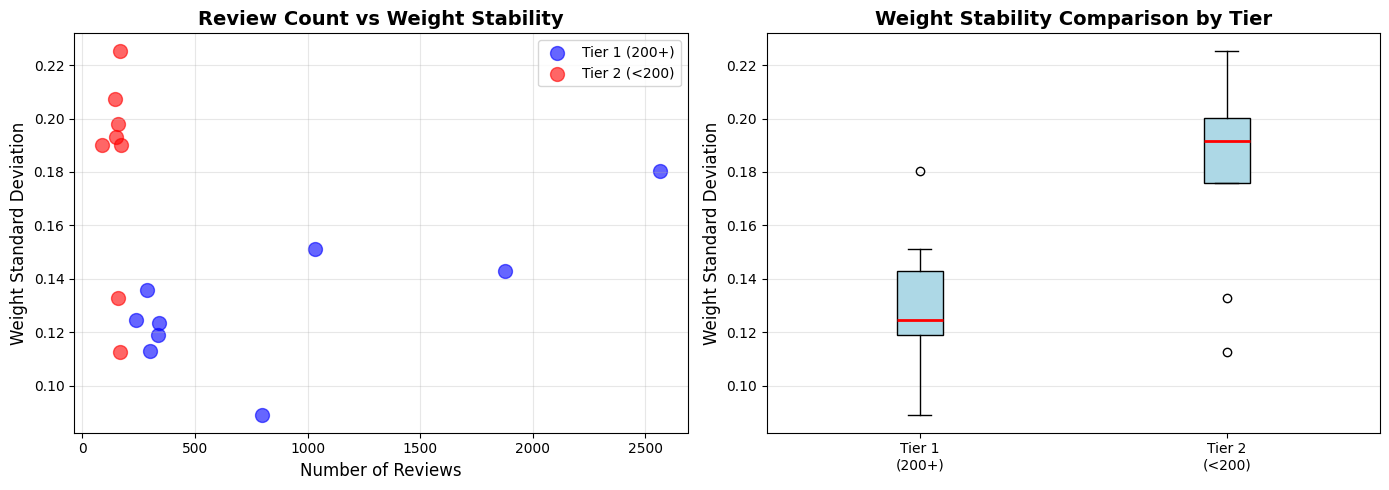

✓ 저장: game_reliability_analysis.png

신뢰도 분석 결과
Tier 1 평균 표준편차: 0.1311
Tier 2 평균 표준편차: 0.1811
차이: 0.0501 (높음)

t-test: t=-3.207, p=0.006
→ 통계적으로 유의한 차이 있음 (p<0.05)


In [43]:
# 리뷰 수 vs 신뢰도 분석

# 각 게임의 가중치 분산 계산 (분산 높음 = 불안정)
game_variance = []

for app_id in game_weights.keys():
    all_weights = []
    for top_name, sub_dict in game_weights[app_id].items():
        all_weights.extend(sub_dict.values())

    variance = np.var(all_weights) if all_weights else 0
    std = np.std(all_weights) if all_weights else 0

    game_variance.append({
        'app_id': app_id,
        'review_count': game_counts[app_id],
        'variance': variance,
        'std': std,
        'tier': "Tier 1" if game_counts[app_id] >= 200 else "Tier 2"
    })

df_variance = pd.DataFrame(game_variance)

# 시각화 (차트 텍스트만 영문)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Review Count vs Weight Std
axes[0].scatter(
    df_variance[df_variance['tier'] == 'Tier 1']['review_count'],
    df_variance[df_variance['tier'] == 'Tier 1']['std'],
    s=100, alpha=0.6, label='Tier 1 (200+)', color='blue'
)
axes[0].scatter(
    df_variance[df_variance['tier'] == 'Tier 2']['review_count'],
    df_variance[df_variance['tier'] == 'Tier 2']['std'],
    s=100, alpha=0.6, label='Tier 2 (<200)', color='red'
)

axes[0].set_xlabel('Number of Reviews', fontsize=12)
axes[0].set_ylabel('Weight Standard Deviation', fontsize=12)
axes[0].set_title('Review Count vs Weight Stability', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Tier-wise Std Comparison
tier1_std = df_variance[df_variance['tier'] == 'Tier 1']['std']
tier2_std = df_variance[df_variance['tier'] == 'Tier 2']['std']

axes[1].boxplot(
    [tier1_std, tier2_std],
    labels=['Tier 1\n(200+)', 'Tier 2\n(<200)'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red', linewidth=2)
)

axes[1].set_ylabel('Weight Standard Deviation', fontsize=12)
axes[1].set_title('Weight Stability Comparison by Tier', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('game_reliability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 저장: game_reliability_analysis.png")

# ======================
# 통계
# ======================
print("\n" + "=" * 60)
print("신뢰도 분석 결과")
print("=" * 60)
print(f"Tier 1 평균 표준편차: {tier1_std.mean():.4f}")
print(f"Tier 2 평균 표준편차: {tier2_std.mean():.4f}")
print(f"차이: {(tier2_std.mean() - tier1_std.mean()):.4f} ({'높음' if tier2_std.mean() > tier1_std.mean() else '낮음'})")

# t-test
from scipy import stats
t_stat, p_value = stats.ttest_ind(tier1_std, tier2_std)
print(f"\nt-test: t={t_stat:.3f}, p={p_value:.3f}")
if p_value < 0.05:
    print("→ 통계적으로 유의한 차이 있음 (p<0.05)")
else:
    print("→ 통계적으로 유의한 차이 없음 (p≥0.05)")


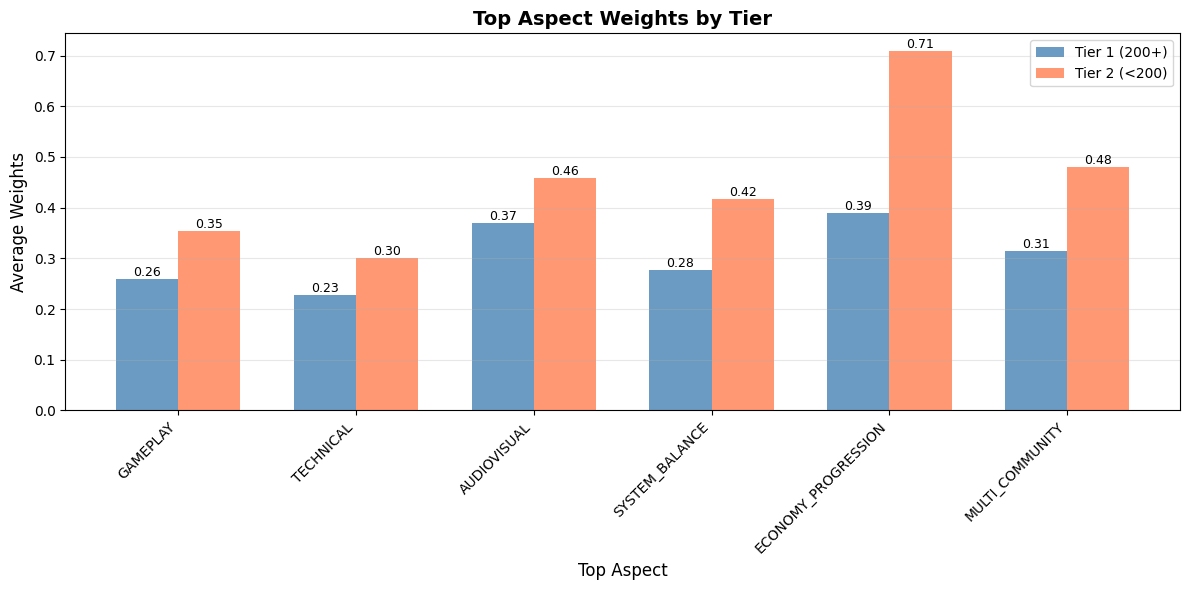

✓ 저장: tier_comparison.png

Tier별 평균 가중치
Top Aspect               Tier 1     Tier 2         차이
------------------------------------------------------------
GAMEPLAY                  0.259      0.354     +0.095
TECHNICAL                 0.228      0.300     +0.072
AUDIOVISUAL               0.370      0.458     +0.088
SYSTEM_BALANCE            0.278      0.417     +0.139
ECONOMY_PROGRESSION       0.389      0.708     +0.319
MULTI_COMMUNITY           0.315      0.479     +0.164


In [46]:
# Tier별 가중치 패턴 비교

# Tier별 평균 가중치
tier1_games = df_game_info[df_game_info['tier'] == 'Tier 1 (200+)']['app_id'].tolist()
tier2_games = df_game_info[df_game_info['tier'] == 'Tier 2 (<200)']['app_id'].tolist()

top_aspects = ['GAMEPLAY', 'TECHNICAL', 'AUDIOVISUAL',
               'SYSTEM_BALANCE', 'ECONOMY_PROGRESSION', 'MULTI_COMMUNITY']

def get_tier_avg_weights(game_list):
    """Tier별 평균 가중치"""
    tier_weights = {top: [] for top in top_aspects}

    for app_id in game_list:
        for top_name in top_aspects:
            avg_w = get_top_avg_weight(game_weights[app_id], top_name)
            if avg_w > 0:
                tier_weights[top_name].append(avg_w)

    # 평균 계산
    tier_avg = {top: np.mean(weights) if weights else 0
                for top, weights in tier_weights.items()}

    return tier_avg

tier1_avg = get_tier_avg_weights(tier1_games)
tier2_avg = get_tier_avg_weights(tier2_games)

# 시각화
x = np.arange(len(top_aspects))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, [tier1_avg[t] for t in top_aspects],
               width, label='Tier 1 (200+)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, [tier2_avg[t] for t in top_aspects],
               width, label='Tier 2 (<200)', color='coral', alpha=0.8)

ax.set_xlabel('Top Aspect', fontsize=12)
ax.set_ylabel('Average Weights', fontsize=12)
ax.set_title('Top Aspect Weights by Tier', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_aspects, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('tier_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 저장: tier_comparison.png")

# 수치 비교
print("\n" + "=" * 60)
print("Tier별 평균 가중치")
print("=" * 60)
print(f"{'Top Aspect':<20} {'Tier 1':>10} {'Tier 2':>10} {'차이':>10}")
print("-" * 60)
for top in top_aspects:
    diff = tier2_avg[top] - tier1_avg[top]
    print(f"{top:<20} {tier1_avg[top]:>10.3f} {tier2_avg[top]:>10.3f} {diff:>+10.3f}")

### 게임별 Top Aspect 분포

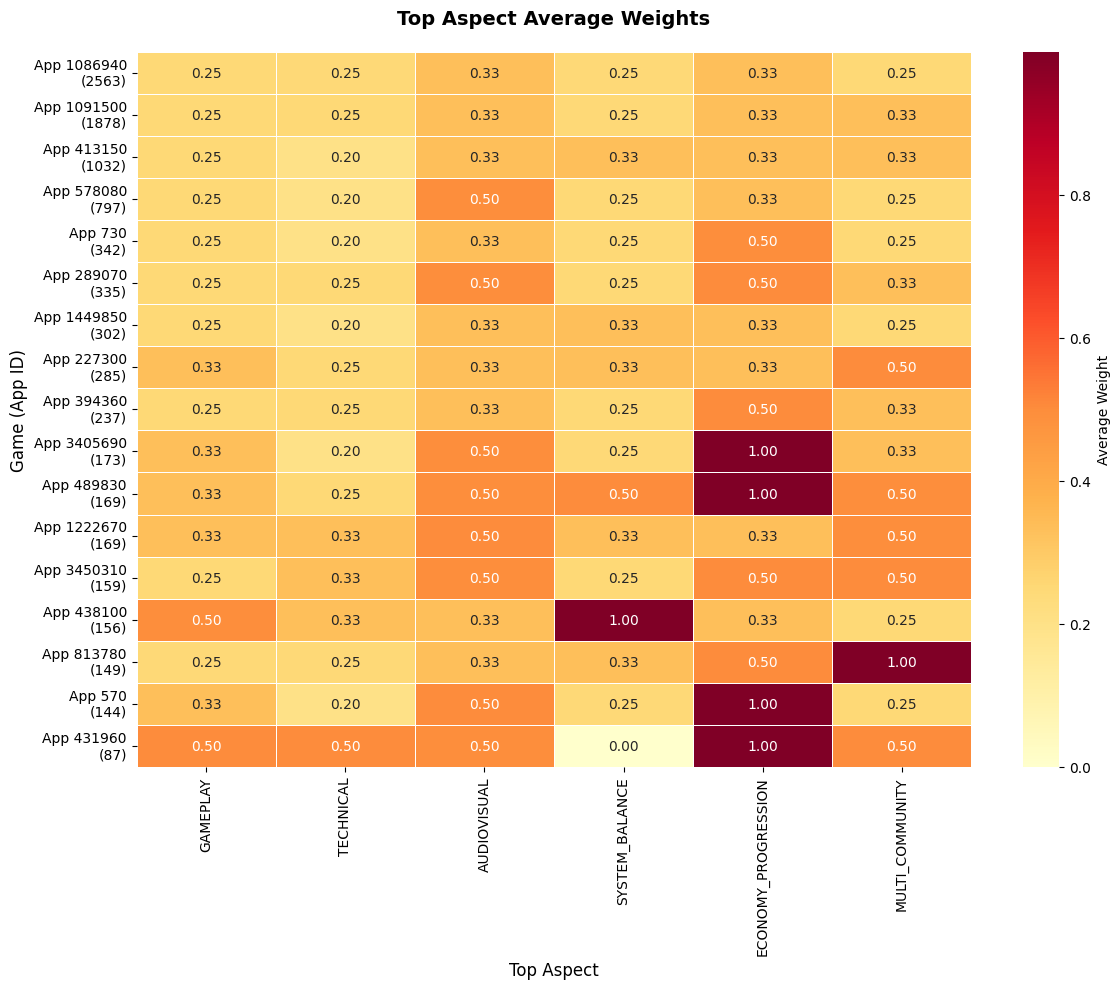

✓ 저장: game_heatmap_all.png


In [47]:
# 게임별 Top Aspect 평균 가중치

def get_top_avg_weight(weights_dict, top_name):
    if top_name not in weights_dict:
        return 0.0
    sub_weights = list(weights_dict[top_name].values())
    return np.mean(sub_weights) if sub_weights else 0.0

# 게임 × Top Aspect 행렬
top_aspects = ['GAMEPLAY', 'TECHNICAL', 'AUDIOVISUAL',
               'SYSTEM_BALANCE', 'ECONOMY_PROGRESSION', 'MULTI_COMMUNITY']

heatmap_data = []
app_ids_sorted = df_game_info['app_id'].tolist()

for app_id in app_ids_sorted:
    row = []
    for top_name in top_aspects:
        avg_weight = get_top_avg_weight(game_weights[app_id], top_name)
        row.append(avg_weight)
    heatmap_data.append(row)

# Heatmap 그리기
plt.figure(figsize=(12, max(10, len(app_ids_sorted) * 0.4)))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=top_aspects,
    yticklabels=[f"App {aid}\n({game_counts[aid]})" for aid in app_ids_sorted],
    cbar_kws={'label': 'Average Weight'},
    linewidths=0.5,
    linecolor='white'
)
plt.title('Top Aspect Average Weights', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Top Aspect', fontsize=12)
plt.ylabel('Game (App ID)', fontsize=12)
plt.tight_layout()
plt.savefig('game_heatmap_all.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 저장: game_heatmap_all.png")

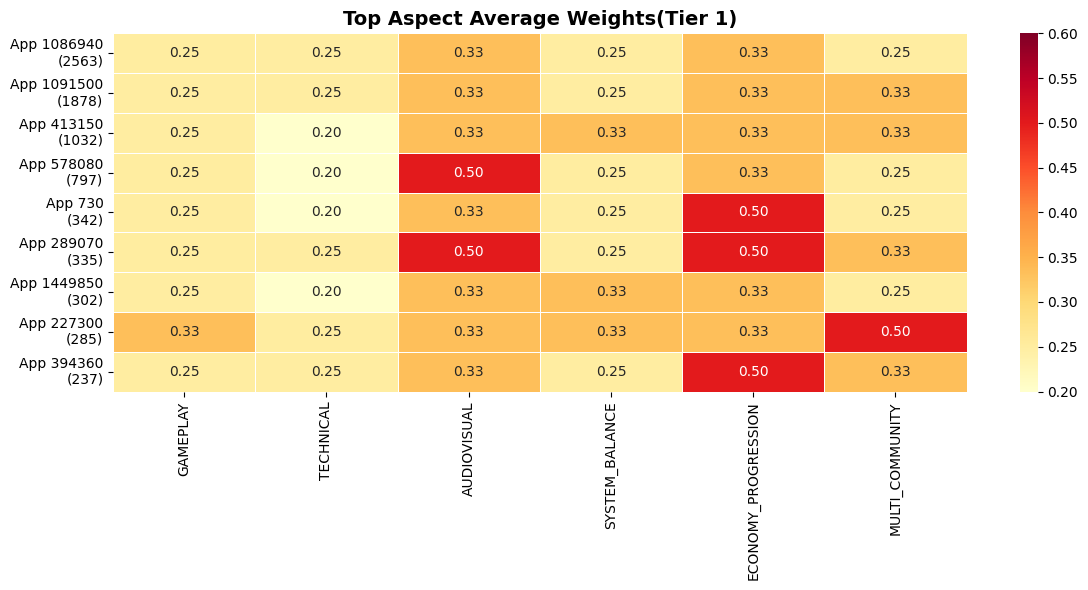

In [48]:
# Tier 1만 따로 분석
tier1_games_only = df_game_info[df_game_info['tier'] == 'Tier 1 (200+)']['app_id'].tolist()

heatmap_data_tier1 = []
for app_id in tier1_games_only:
    row = []
    for top_name in top_aspects:
        avg_weight = get_top_avg_weight(game_weights[app_id], top_name)
        row.append(avg_weight)
    heatmap_data_tier1.append(row)

# 히트맵 (Tier 1만)
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data_tier1,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    vmin=0.2, vmax=0.6,  # 스케일 조정!
    xticklabels=top_aspects,
    yticklabels=[f"App {aid}\n({game_counts[aid]})" for aid in tier1_games_only],
    linewidths=0.5
)
plt.title('Top Aspect Average Weights(Tier 1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('game_heatmap_tier1_only.png', dpi=150)
plt.show()

### 게임별 전체 가중치 분석

In [49]:
# 게임별 가중치 표 생성 (Long Format)

import pandas as pd

# 데이터 수집
weights_data = []

for app_id in sorted(game_weights.keys(), key=lambda x: game_counts[x], reverse=True):
    review_count = game_counts[app_id]
    tier = "Tier 1" if review_count >= 200 else "Tier 2"

    for top_name, sub_dict in game_weights[app_id].items():
        for sub_name, weight in sub_dict.items():
            weights_data.append({
                'App_ID': app_id,
                'Review_Count': review_count,
                'Tier': tier,
                'Top_Aspect': top_name,
                'Sub_Aspect': sub_name,
                'Weight': weight
            })

# DataFrame 생성
df_weights = pd.DataFrame(weights_data)

# 정렬 (리뷰 수 많은 순 → Top → Sub)
df_weights = df_weights.sort_values(['Review_Count', 'Top_Aspect', 'Sub_Aspect'],
                                     ascending=[False, True, True])

print("=" * 80)
print("게임별 가중치 표 (Long Format)")
print("=" * 80)
print(df_weights.to_string(index=False))

# CSV 저장
df_weights.to_csv('game_weights_table.csv', index=False, encoding='utf-8-sig')
print("\n✓ 저장: game_weights_table.csv")

게임별 가중치 표 (Long Format)
 App_ID  Review_Count   Tier          Top_Aspect         Sub_Aspect   Weight
1086940          2563 Tier 1         AUDIOVISUAL        AV_GRAPHICS 0.428439
1086940          2563 Tier 1         AUDIOVISUAL           AV_SOUND 0.168761
1086940          2563 Tier 1         AUDIOVISUAL         AV_UI_FEEL 0.402801
1086940          2563 Tier 1 ECONOMY_PROGRESSION   ECO_MONETIZATION 0.784550
1086940          2563 Tier 1 ECONOMY_PROGRESSION    ECO_PROGRESSION 0.210556
1086940          2563 Tier 1 ECONOMY_PROGRESSION         ECO_REWARD 0.004894
1086940          2563 Tier 1            GAMEPLAY          GP_COMBAT 0.225364
1086940          2563 Tier 1            GAMEPLAY         GP_CONTENT 0.323503
1086940          2563 Tier 1            GAMEPLAY         GP_CONTROL 0.158671
1086940          2563 Tier 1            GAMEPLAY             GP_FUN 0.292463
1086940          2563 Tier 1     MULTI_COMMUNITY COMMUNITY_BEHAVIOR 0.053429
1086940          2563 Tier 1     MULTI_COMMUNITY    

In [50]:
# 게임별 주요 특징 추출


print("\n" + "=" * 60)
print("게임별 주요 특징 (가중치 상위 3개)")
print("=" * 60)

for app_id in df_game_info['app_id']:  # 상위 10개만
    review_count = game_counts[app_id]
    tier = "Tier 1" if review_count >= 200 else "Tier 2"

    print(f"\n[ App {app_id} - {review_count}개 리뷰 ({tier}) ]")

    # 모든 sub_aspect 가중치 수집
    all_subs = []
    for top_name, sub_dict in game_weights[app_id].items():
        for sub_name, weight in sub_dict.items():
            all_subs.append({
                'top': top_name,
                'sub': sub_name,
                'weight': weight
            })

    # 가중치 높은 순 정렬
    all_subs.sort(key=lambda x: x['weight'], reverse=True)

    # 상위 5개
    print("  주요 요소:")
    for i, item in enumerate(all_subs[:5], 1):
        print(f"    {i}. {item['sub']} ({item['top']}): {item['weight']*100:.1f}%")


게임별 주요 특징 (가중치 상위 3개)

[ App 1086940 - 2563개 리뷰 (Tier 1) ]
  주요 요소:
    1. ECO_MONETIZATION (ECONOMY_PROGRESSION): 78.5%
    2. MULTI_SOCIAL (MULTI_COMMUNITY): 52.5%
    3. TECH_NET (TECHNICAL): 44.2%
    4. AV_GRAPHICS (AUDIOVISUAL): 42.8%
    5. AV_UI_FEEL (AUDIOVISUAL): 40.3%

[ App 1091500 - 1878개 리뷰 (Tier 1) ]
  주요 요소:
    1. ECO_REWARD (ECONOMY_PROGRESSION): 57.3%
    2. AV_UI_FEEL (AUDIOVISUAL): 51.3%
    3. MULTI_SOCIAL (MULTI_COMMUNITY): 49.8%
    4. MULTI_FAIRNESS (MULTI_COMMUNITY): 47.2%
    5. SYS_BALANCE (SYSTEM_BALANCE): 39.9%

[ App 413150 - 1032개 리뷰 (Tier 1) ]
  주요 요소:
    1. SYS_DIFFICULTY (SYSTEM_BALANCE): 68.4%
    2. MULTI_FAIRNESS (MULTI_COMMUNITY): 48.2%
    3. ECO_PROGRESSION (ECONOMY_PROGRESSION): 44.7%
    4. AV_UI_FEEL (AUDIOVISUAL): 44.0%
    5. COMMUNITY_BEHAVIOR (MULTI_COMMUNITY): 42.0%

[ App 578080 - 797개 리뷰 (Tier 1) ]
  주요 요소:
    1. AV_GRAPHICS (AUDIOVISUAL): 52.2%
    2. AV_SOUND (AUDIOVISUAL): 47.8%
    3. ECO_MONETIZATION (ECONOMY_PROGRESSION): 40.5

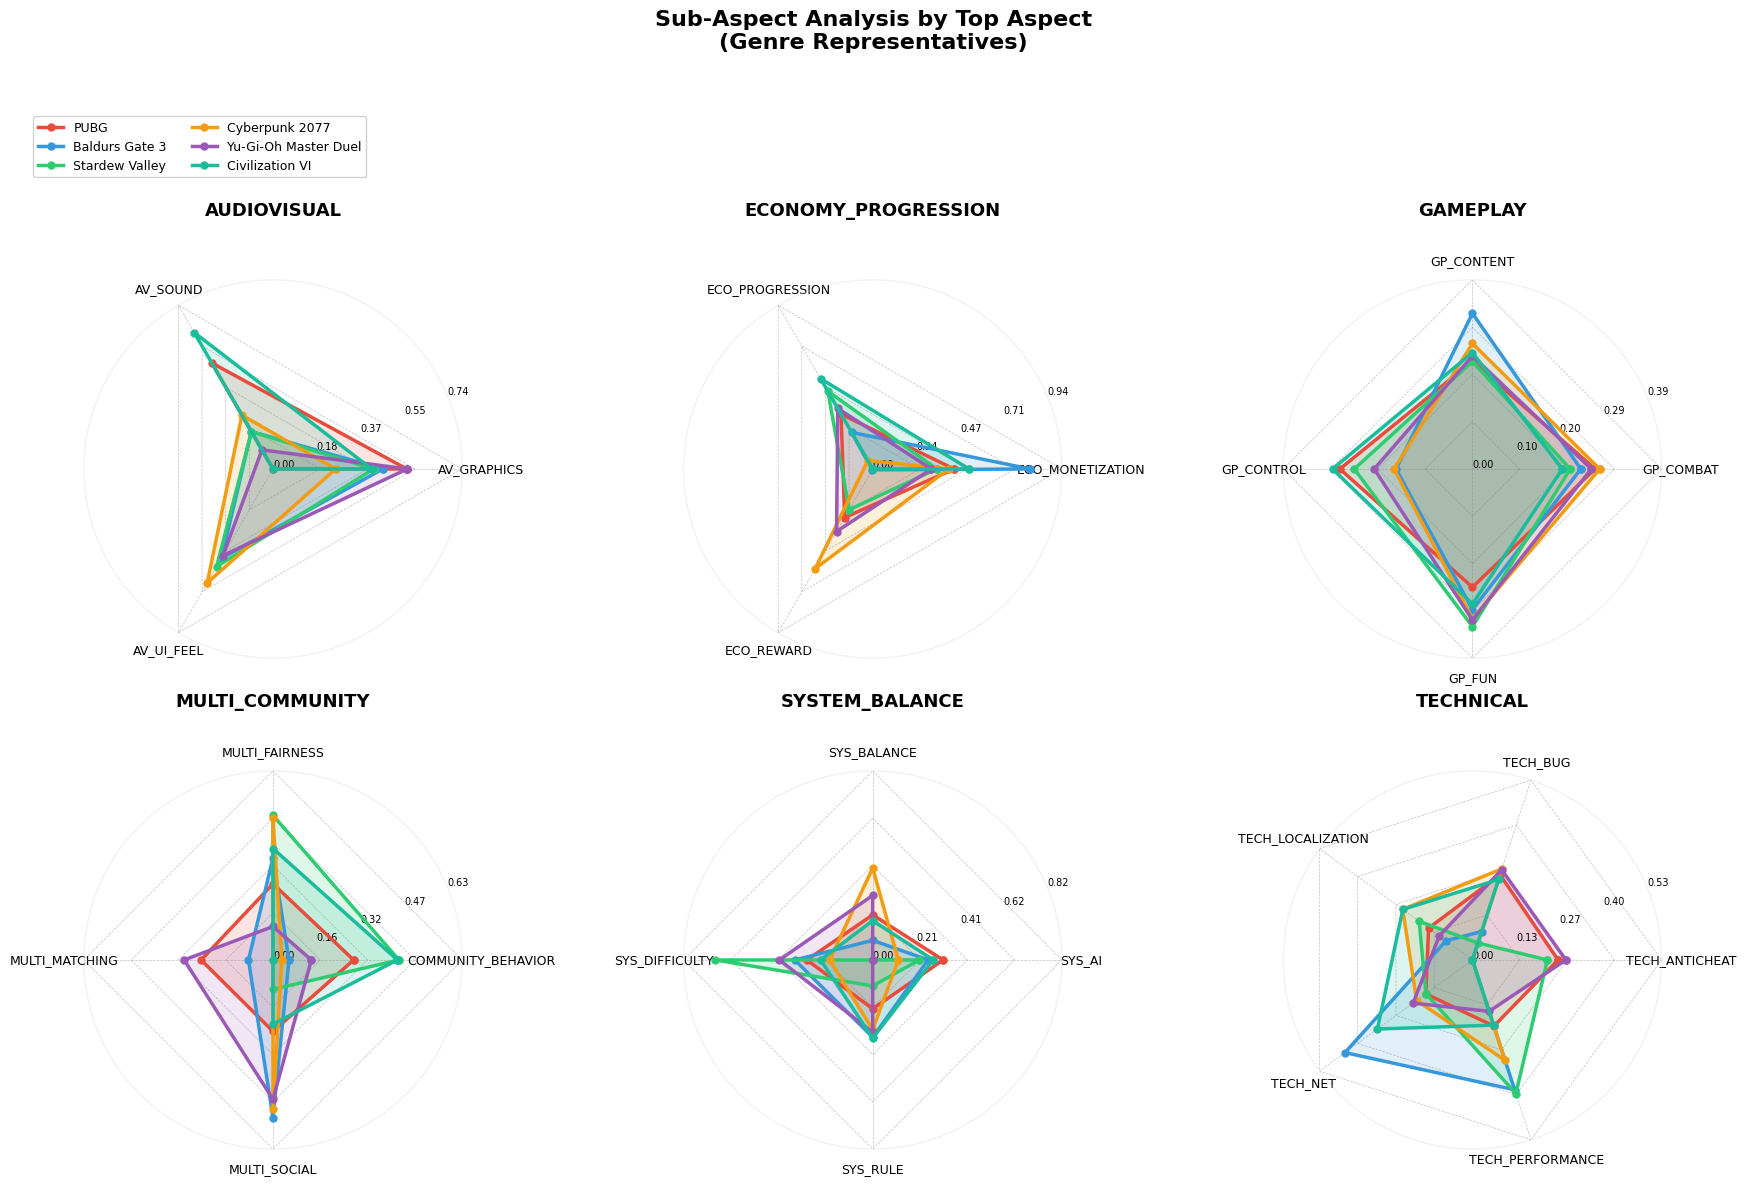


Saved: radar_grid_all.png


In [51]:
# ============================================
# (동일한 코드, 원 테두리만 수정)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

df = pd.read_csv('game_weights_table.csv')

# Genre Representatives (동일)
genre_data = {
    'Action': [730, 570, 578080],
    'Adventure': [1086940, 438100, 1222670],
    'Casual/Indie': [431960, 413150, 227300],
    'RPG': [1091500, 489830],
    'Simulation': [3405690, 394360, 1449850],
    'Strategy': [289070, 3450310, 813780],
}

genre_representatives = {}
for genre, game_list in genre_data.items():
    genre_df = df[df['App_ID'].isin(game_list)]
    if len(genre_df) == 0:
        continue
    top_game = genre_df.groupby('App_ID')['Review_Count'].first().idxmax()
    review_count = genre_df.groupby('App_ID')['Review_Count'].first().max()
    genre_representatives[genre] = {'app_id': top_game, 'reviews': review_count}

game_info = {}
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']

for i, (genre, info) in enumerate(genre_representatives.items()):
    app_id = info['app_id']
    game_names = {
        578080: 'PUBG', 1086940: 'Baldurs Gate 3', 413150: 'Stardew Valley',
        1091500: 'Cyberpunk 2077', 1449850: 'Yu-Gi-Oh Master Duel', 289070: 'Civilization VI',
    }
    name = game_names.get(app_id, f'App {app_id}')
    game_info[app_id] = {'name': name, 'genre': genre, 'color': colors[i % len(colors)]}

selected_games = list(game_info.keys())

def create_grid_radar_charts(df, game_info, selected_games):
    """Create 2x3 grid with lighter circle border"""

    top_aspects = sorted(df['Top_Aspect'].unique())
    fig = plt.figure(figsize=(18, 12))

    for idx, top_aspect in enumerate(top_aspects, 1):
        ax = plt.subplot(2, 3, idx, projection='polar')

        top_data = df[df['Top_Aspect'] == top_aspect]
        sub_aspects = sorted(top_data['Sub_Aspect'].unique())

        if len(sub_aspects) == 0:
            continue

        game_data = []
        game_labels = []
        game_colors = []

        for app_id in selected_games:
            game_sub_data = top_data[top_data['App_ID'] == app_id]
            weights = []
            for sub in sub_aspects:
                sub_row = game_sub_data[game_sub_data['Sub_Aspect'] == sub]
                weight = sub_row['Weight'].values[0] if len(sub_row) > 0 else 0
                weights.append(weight)

            if sum(weights) > 0:
                game_data.append(weights)
                game_labels.append(game_info[app_id]['name'])
                game_colors.append(game_info[app_id]['color'])

        if len(game_data) == 0:
            continue

        num_vars = len(sub_aspects)
        angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
        angles += angles[:1]

        max_value = max([max(d) for d in game_data]) if game_data else 1
        ax.set_ylim(0, max_value * 1.2)

        # Polygon grid
        grid_levels = np.linspace(0, max_value * 1.2, 5)
        for level in grid_levels[1:]:
            polygon = [level] * num_vars + [level]
            ax.plot(angles, polygon, color='gray', linewidth=0.5,
                   linestyle='--', alpha=0.5)

        for angle in angles[:-1]:
            ax.plot([angle, angle], [0, max_value * 1.2],
                   color='gray', linewidth=0.5, linestyle='--', alpha=0.5)

        ax.grid(False)

        # Plot data
        for data, label, color in zip(game_data, game_labels, game_colors):
            values = data + data[:1]
            ax.plot(angles, values, 'o-', linewidth=2.5, label=label,
                   color=color, markersize=5)
            ax.fill(angles, values, alpha=0.15, color=color)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(sub_aspects, size=9)
        ax.set_yticks(grid_levels)
        ax.set_yticklabels([f'{val:.2f}' for val in grid_levels], size=7)
        ax.set_title(f'{top_aspect}', size=13, fontweight='bold', pad=25, y=1.08)

        # === 원 테두리 연하게 ===
        ax.spines['polar'].set_color('lightgray')  # 색상 연하게
        ax.spines['polar'].set_alpha(0.3)          # 투명도 추가
        ax.spines['polar'].set_linewidth(1)        # 선 굵기도 얇게

        if idx == 1:
            ax.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.45),
                     fontsize=9, ncol=2, framealpha=0.9)

    fig.suptitle('Sub-Aspect Analysis by Top Aspect\n(Genre Representatives)',
                 size=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('radar_grid_all.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nSaved: radar_grid_all.png")

create_grid_radar_charts(df, game_info, selected_games)